# Modelling

This notebok contains code for our models. It includes:
- SVM
- K nearst neighbour
- XGBoost 

The SVM is our baseline model, specifically all data with the original level and no level balancing is our baseline model.

This notebook also contains a bit of EDA.

# Installing Packages

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install yellowbrick
!{sys.executable} -m pip install matplot
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install xgboost

# Preprocessing of Data

In [291]:
import os
import copy
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer

# Helper function: simply reads a csv file and return it as a dataframe
def read_data(data_file):
  data_df = pd.read_csv(data_file)
  return data_df

def drop_features(data_df, features_to_drop):
  return data_df.drop(columns=features_to_drop, inplace=True)

def segregate_noisy_data(data_df):
  copied_data = copy.deepcopy(data_df)
  non_noisy_df = copied_data.loc[(copied_data['noisy_train'] == 0)]
  noisy_df = copied_data.loc[(copied_data['noisy_train'] == 1)]
  return non_noisy_df, noisy_df

def remove_noisy_data(data_df):
  print(f'''Rows dropped because of noisy == 1: 
        {len(data_df[data_df['noisy'] == 1])}\n''')
  
  return data_df.drop(data_df[data_df['noisy'] == 1].index, inplace=True)

# Helper function: cleans data based on xyz
def preprocessing_data(data_df):

  # Clean data based on duration value
  print(f'''Rows dropped because of low duration: \
        {len(data_df[data_df['duration'] < 2])}\n''')
  
  data_df.drop(data_df[data_df['duration'] < 2].index, inplace=True)

  # Extract filenames
  filenames = data_df['file_name'].values.tolist()

  return (data_df, filenames)


Read Data

In [292]:
# Fetch .csv file and store it as a dataframe
aggression_data_df = read_data('../extracted/full-train-features.csv')

Extract data, filenames and labels after preprocessing data

In [293]:
print(f'Shape of the data before cleaning it: {aggression_data_df.shape}\n')
print(aggression_data_df.tail())

aggression_data_df, filenames = preprocessing_data(aggression_data_df)

print(f'Shape of the data after cleaning it: {aggression_data_df.shape} \n')

Shape of the data before cleaning it: (2146, 23)

                      file_name  duration  analyse_harmonics  \
2141  xdz15thrnem51_processed_5      10.0           5.465491   
2142  xdz15thrnem51_processed_6      10.0           6.879443   
2143  xdz15thrnem51_processed_7      10.0           4.468770   
2144  xdz15thrnem51_processed_8      10.0           8.581945   
2145  xdz15thrnem51_processed_9      10.0           2.829222   

      get_number_sylls  get_number_words  pauses  get_max_intensity  \
2141               1.3               1.0     0.1         104.113896   
2142               0.2               0.3     0.1         108.028173   
2143               1.8               1.1     0.1         104.678268   
2144               0.3               0.1     0.1         109.335715   
2145               0.6               0.6     0.1         105.455598   

      analyse_intensity  analyse_pitch  analyse_pitch_range  ...  \
2141          69.550541     199.893943           443.057705  ...   
21

Segregate data based on noisy vs not noisy

In [294]:
non_noisy_df, noisy_df = segregate_noisy_data(aggression_data_df)

print(f"Shape of noisy data: {noisy_df.shape} \n")
print(f"Shape of non noisy data: {non_noisy_df.shape}\n")

Shape of noisy data: (262, 23) 

Shape of non noisy data: (1849, 23)



**NOTE: Modelling of this project is split into 3 groups. Therefore, all the steps in this notebook below are repeated once for each group**
1. Noisy and Non Noisy Data
2. Non Noisy Data
3. Noisy Data

Drop features

In [295]:
features_to_drop = ['file_name', 'duration','get_number_sylls',
                    'get_number_words', 'pauses',
                    'number_of_segments_train', 'number_of_voices_parent_train',
                    'extra_sounds_train', 'Notes_train']

# remove features for Group 1
print(f'Shape of the data for Group 1 before dropping features: {aggression_data_df.shape} \n')
drop_features(aggression_data_df, features_to_drop)

# remove features for Group 2
print(f'Shape of the data for Group 2 before dropping features: {non_noisy_df.shape} \n')
drop_features(non_noisy_df, features_to_drop)

# remove features for Group 3
print(f'Shape of the data for Group 3 before dropping features: {noisy_df.shape} \n')
drop_features(noisy_df, features_to_drop)


print(f'Shape of the data for Group 1 after dropping features: {aggression_data_df.shape} \n')
print(f'Shape of the data for Group 2 after dropping features: {non_noisy_df.shape} \n')
print(f'Shape of the data for Group 3 after dropping features: {noisy_df.shape} \n')

Shape of the data for Group 1 before dropping features: (2111, 23) 

Shape of the data for Group 2 before dropping features: (1849, 23) 

Shape of the data for Group 3 before dropping features: (262, 23) 

Shape of the data for Group 1 after dropping features: (2111, 14) 

Shape of the data for Group 2 after dropping features: (1849, 14) 

Shape of the data for Group 3 after dropping features: (262, 14) 



Remove rows that have `NaN` as one of the feature values

1 row in both group 1 and group 2 have `NaN`

In [297]:
aggression_data_df.dropna(inplace=True)
non_noisy_df.dropna(inplace=True)
noisy_df.dropna(inplace=True)


Convert values in 'get_max_intensity' from string to float 

In [298]:
aggression_data_df['get_max_intensity'] = pd.to_numeric(aggression_data_df['get_max_intensity'])
non_noisy_df['get_max_intensity'] = pd.to_numeric(non_noisy_df['get_max_intensity'])
noisy_df['get_max_intensity'] = pd.to_numeric(noisy_df['get_max_intensity'])

noisy_df.head(5)

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,2.071884,108.591944,76.429126,355.354649,517.899150,0.193371,0.039075,-0.091534,1711.357507,0.174962,00g8dfgpqpt61,0,0,1
1,1.548685,107.108480,78.207339,409.030438,491.537960,0.202199,0.049623,-0.090760,1469.373610,0.263521,00g8dfgpqpt62,0,0,1
2,2.202973,110.003934,77.650102,393.605328,511.080779,0.200674,0.038352,-0.116676,1287.538989,0.231453,00g8dfgpqpt63,0,0,1
3,4.541632,100.037201,67.432142,358.021668,448.489253,0.201583,0.035544,-0.010975,1251.558111,0.022047,01avx2fm1t961,3,3,1
4,3.790801,98.041081,63.570349,373.512829,519.744413,0.190743,0.046422,-0.004044,1387.495977,0.009121,01avx2fm1t961,3,2,1


Segregate data df and label df and reset indexes from all groups

In [299]:
feature_labels = ['parent_label_train', 'segment_label_train', 'noisy_train']

label_df = aggression_data_df.filter(items=feature_labels)
aggression_df = aggression_data_df#.drop(columns=feature_labels)

label_non_noisy_df = non_noisy_df.filter(items=feature_labels)
aggression_non_noisy_df = non_noisy_df#.drop(columns=feature_labels)

label_noisy_df = noisy_df.filter(items=feature_labels)
aggression_noisy_df = noisy_df#.drop(columns=feature_labels)

label_df.reset_index(drop=True, inplace=True)
aggression_df.reset_index(drop=True, inplace=True)

label_non_noisy_df.reset_index(drop=True, inplace=True)
aggression_non_noisy_df.reset_index(drop=True, inplace=True)

label_noisy_df.reset_index(drop=True, inplace=True)
aggression_noisy_df.reset_index(drop=True, inplace=True)

print(f"Shape of labelled data in Group 1:{label_df.shape} \nShape of data in Group 1: {aggression_df.shape}\n")
print(f"Shape of labelled data in Group 2:{label_non_noisy_df.shape} \nShape of data in Group 2: {aggression_non_noisy_df.shape}\n")
print(f"Shape of labelled data in Group 3:{label_noisy_df.shape} \nShape of data in Group 3: {aggression_noisy_df.shape}\n")

Shape of labelled data in Group 1:(2110, 3) 
Shape of data in Group 1: (2110, 14)

Shape of labelled data in Group 2:(1848, 3) 
Shape of data in Group 2: (1848, 14)

Shape of labelled data in Group 3:(262, 3) 
Shape of data in Group 3: (262, 14)



# Standardization

In [300]:
from sklearn.preprocessing import StandardScaler

# Helper function: returns a standardized dataframe
def standardize(df):
    org_features = df.columns
    features = [i for i in df.columns if i not in ['parent_file_train'] + feature_labels]
    
    values_array = df.loc[:, features].values

    # Print data before standardization to compare
    print("Before Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape} \n")

    # Invoke standardization
    # Numeric columns: Std scaler
    pipeline = ColumnTransformer([
        ('transform_numeric',StandardScaler(),features),    
    ], remainder='passthrough')


    # Transform input vector (features)
    df =  pd.DataFrame(pipeline.fit_transform(df),columns=org_features)
    
    #values_array = StandardScaler().fit_transform(values_array)
    
    values_array = df.loc[:, features].values  # To do the below computation
    # Print data after standardization to compare
    print("After Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape}")

    return df

Standardize data for all groups

In [301]:
standardized_aggression_df = standardize(aggression_df)
standardized_non_noisy_df = standardize(aggression_non_noisy_df)
standardized_noisy_df = standardize(aggression_noisy_df)

Before Standardization 

Mean and Standard Deviation
Mean = 207.03214462485482 ; Standard Deviation = 405.89809500083527
Shape to verify: (2110, 10) 

After Standardization 

Mean and Standard Deviation
Mean = -2.323904628500039e-17 ; Standard Deviation = 0.9999999999999954
Shape to verify: (2110, 10)
Before Standardization 

Mean and Standard Deviation
Mean = 207.29693013792163 ; Standard Deviation = 410.78706249224183
Shape to verify: (1848, 10) 

After Standardization 

Mean and Standard Deviation
Mean = 1.3256741784163884e-16 ; Standard Deviation = 1.000000000000001
Shape to verify: (1848, 10)
Before Standardization 

Mean and Standard Deviation
Mean = 205.16449718917747 ; Standard Deviation = 369.5763759893764
Shape to verify: (262, 10) 

After Standardization 

Mean and Standard Deviation
Mean = 1.6776232650728988e-16 ; Standard Deviation = 0.9999999999999989
Shape to verify: (262, 10)


In [155]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


# Modelling

In [302]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import svm, mixture
from sklearn.model_selection import GridSearchCV, train_test_split

def hyperparameter_tuning(ml_model, data, label, parameters):
    clf = GridSearchCV(ml_model, parameters, refit=True, verbose=0, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    clf.fit(data, label)
    print(clf.best_params_)

def run_model(ml_model, data, label, label_name):
    model = copy.deepcopy(ml_model)
    
    # Only train on this feature set
    feature_set = data.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    print('Feature set:',feature_set)
    
    actual_labels = np.empty([0], dtype=int)
    predicted_labels = np.empty([0], dtype=int)

    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
    
    
    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    
    X_test['segment_predictions'] = y_pred  # To store prediction with rest of the data
    #X_test['segment_actual'] = y_test  # To store prediction with rest of the data

    actual_labels = np.append(actual_labels, y_test)
    predicted_labels = np.append(predicted_labels, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred, average='weighted')
    rec_score = recall_score(y_test, y_pred, average='weighted')
    fone_score = f1_score(y_test, y_pred, average='weighted')

    print(f'F1 score = {fone_score}; Accuracy score = {acc_score} ; Precisison Score = {prec_score}; Recall score = {rec_score}')

    return actual_labels, predicted_labels, X_test

def confusion_matrix_graph(model_name, actual_labels, predicted_labels, label_names):
    matrix = confusion_matrix(actual_labels, predicted_labels)

    plt.figure(figsize=(14, 8))
    ax = sns.heatmap(matrix, annot=True, xticklabels=label_names, yticklabels=label_names, cmap="Greens")
    ax.set_title(model_name);
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual');

    print("\n\n Aggregate report \n", classification_report(actual_labels, predicted_labels, target_names=label_names))

    plt.show()    



Convert dataframes to numpy array

In [303]:
data_np = standardized_aggression_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_np = label_df['segment_label_train'].to_numpy()

data_non_noisy_np = standardized_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_non_noisy_np = label_non_noisy_df['segment_label_train'].to_numpy()

data_noisy_np = standardized_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_noisy_np = label_noisy_df['segment_label_train'].to_numpy()

C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2163191907.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_np = standardized_aggression_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2163191907.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_non_noisy_np = standardized_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2163191907.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_noisy_np = standardized_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "no

## SVM

Hyperparameter Tuning for SVM

In [ ]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_np, label_np, quick_parameters)
hyperparameter_tuning(svc, data_non_noisy_np, label_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_noisy_np, label_noisy_np, quick_parameters)

***NOTE: `orginal_parameters` were the actual parameters against which the parameters were tuned. However, the results took over 4 hours to be processed. Therefore, `quick_parameters` is just a smaller subset of the `original_parameters`.***

Results from hyper parameter tuning for the three groups using SVM

Group 1 (all data): {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Group 2 (non noisy): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Group 3 (noisy): {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

#### Segment analysis vs Parent analysis 
***We further conduct more exploration of our data by running our models on  `segment` vs `parent` labelled data in the following code blocks.***

- Our labelled data consists of `segment` audio files and `parent` audio files. 
- `Segment` audio files are just smaller subsets of the `parent` audio file.
- Each `segment` has a corresponding `segment_label`
- Similarly, each parent has a corresponding `parent_label` which takes the maximum label from its `segment_labels`
- *Segment vs Parent analysis happens throughout this notebook from here on*

## Segment Analysis on all groups - Baseline model for our segment analysis

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5134010802840334; Accuracy score = 0.5359848484848485 ; Precisison Score = 0.5162978096733759; Recall score = 0.5359848484848485


 Aggregate report 
               precision    recall  f1-score   support

           0       0.61      0.77      0.68       227
           1       0.44      0.46      0.45       152
           2       0.42      0.19      0.26        94
           3       0.50      0.36      0.42        55

    accuracy                           0.54       528
   macro avg       0.49      0.45      0.45       528
weighted avg       0.52      0.54      0.51       528



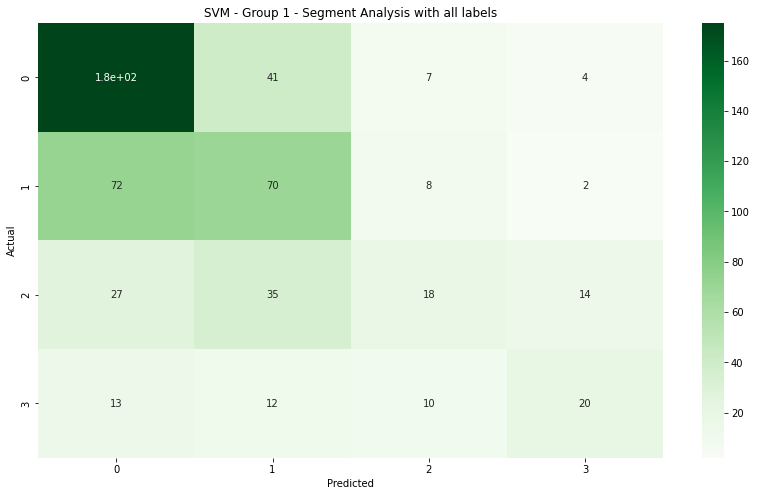

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5617771374218329; Accuracy score = 0.5670995670995671 ; Precisison Score = 0.5681046314219454; Recall score = 0.5670995670995671


 Aggregate report 
               precision    recall  f1-score   support

           0       0.69      0.67      0.68       195
           1       0.49      0.62      0.55       141
           2       0.47      0.33      0.39        86
           3       0.48      0.38      0.42        40

    accuracy                           0.57       462
   macro avg       0.53      0.50      0.51       462
weighted avg       0.57      0.57      0.56       462



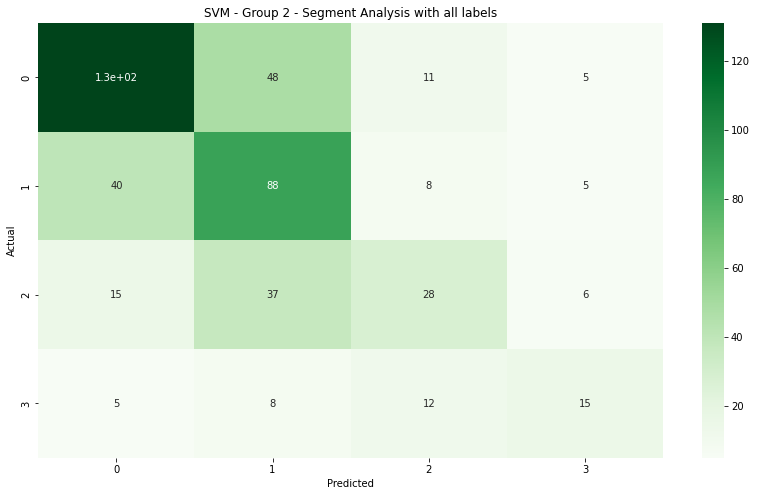

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6794777038679477; Accuracy score = 0.7272727272727273 ; Precisison Score = 0.637741046831956; Recall score = 0.7272727272727273


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




 Aggregate report 
               precision    recall  f1-score   support

           0       0.77      0.89      0.83        38
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         6
           3       0.64      0.70      0.67        20

    accuracy                           0.73        66
   macro avg       0.35      0.40      0.37        66
weighted avg       0.64      0.73      0.68        66



C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

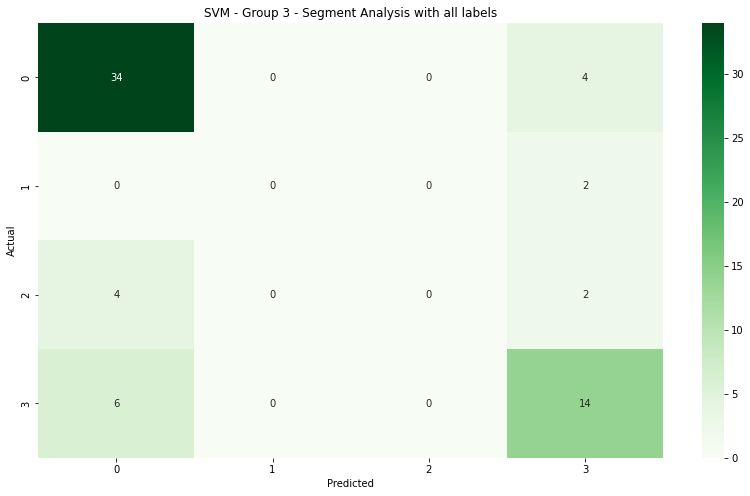

In [305]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_np, label_non_noisy_np, label_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df, standardized_non_noisy_df, standardized_noisy_df]
X_test_list = [None,None,None]
gamma = ['auto', 'scale', 'auto']
c = [1, 10, 1]

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1} - Segment Analysis with all labels", actual, predicted, ['0', '1', '2', '3'])

## Parent Analysis on all groups - Baseline model for our parent analysis



 Aggregate report 
               precision    recall  f1-score   support

           0       0.53      0.71      0.60        69
           1       0.31      0.39      0.34        54
           2       0.27      0.13      0.18        45
           3       0.68      0.42      0.52        40

    accuracy                           0.45       208
   macro avg       0.45      0.41      0.41       208
weighted avg       0.44      0.45      0.43       208



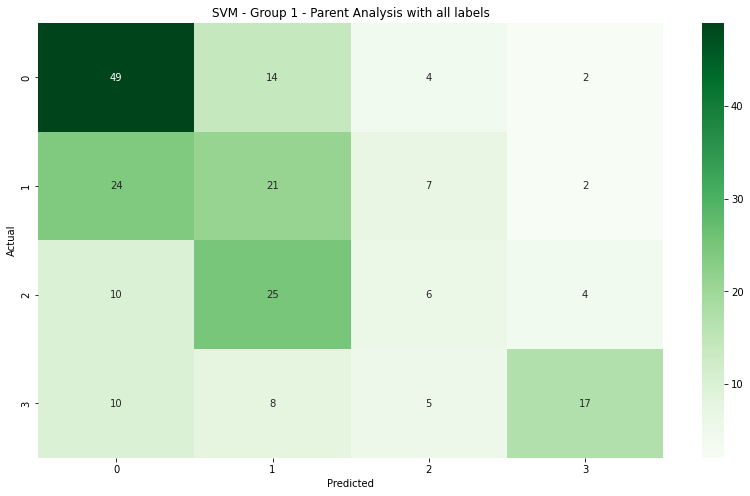



 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.60      0.60        53
           1       0.39      0.56      0.46        52
           2       0.37      0.31      0.34        42
           3       0.47      0.26      0.33        35

    accuracy                           0.46       182
   macro avg       0.46      0.43      0.43       182
weighted avg       0.46      0.46      0.45       182



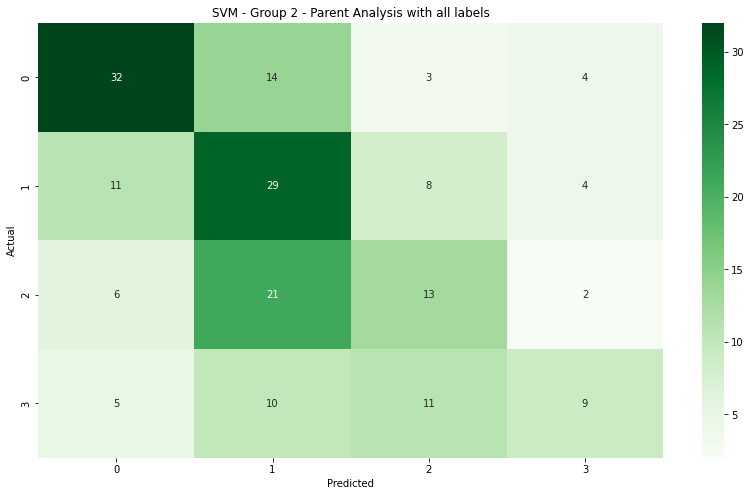

C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo



 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.94      0.79        16
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         3
           3       0.62      0.73      0.67        11

    accuracy                           0.66        35
   macro avg       0.32      0.42      0.36        35
weighted avg       0.51      0.66      0.57        35



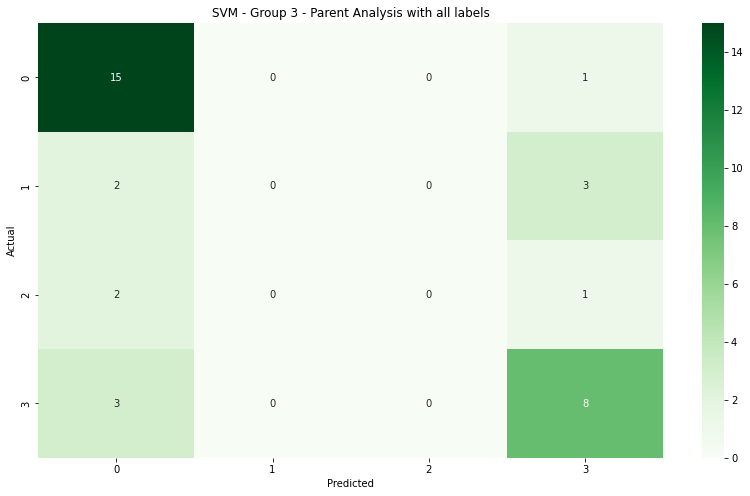

In [307]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1} - Parent Analysis with all labels", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

### EDA: Test combining level 1 and level 2 as they appear to have difficulty in classifying

Instead of having 4 distinct labels: 0, 1, 2, 3 we will now merge some labels and have 3 distinct labels: 0, 1, 2 in hope of better classification results.

In [308]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


#### Combine the labels in all dataframes
- Label 2 is merged to label 1 for both parent and segment analysis.
- Label 3 is merged to label 2 for both parent and segment analysis.

In [309]:
standardized_aggression_mergedlabels_df = standardized_aggression_df.copy()
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 2, 'segment_label_train' ] = 1
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 3, 'segment_label_train'] = 2
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['parent_label_train'] == 2, 'parent_label_train'] = 1
standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['parent_label_train'] == 3, 'parent_label_train'] = 2
print(standardized_aggression_mergedlabels_df['segment_label_train'].unique())
print(standardized_aggression_mergedlabels_df['parent_label_train'].unique())

[0 2 1]
[0 2 1]


In [310]:
standardized_mergedlabels_non_noisy_df = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['noisy_train'] == 0]
standardized_mergedlabels_noisy_df = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['noisy_train'] == 1]

Convert to numpy arrays for the three groups (all data, non-noisy, noisy)

In [311]:
data_merged_np = standardized_aggression_mergedlabels_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_np = standardized_aggression_mergedlabels_df['segment_label_train'].to_numpy()
label_merged_np=label_merged_np.astype('int')

data_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df['segment_label_train'].to_numpy()
label_merged_non_noisy_np=label_merged_non_noisy_np.astype('int')

data_merged_noisy_np = standardized_mergedlabels_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_merged_noisy_np = standardized_mergedlabels_noisy_df['segment_label_train'].to_numpy()
label_merged_noisy_np=label_merged_noisy_np.astype('int')

C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2370931604.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_merged_np = standardized_aggression_mergedlabels_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2370931604.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2370931604.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_merged_noisy_np = standardized_mergedlabels_noisy_df.drop(["parent_f

Get new hyper params

In [ ]:
quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_merged_np, label_merged_np, quick_parameters)
hyperparameter_tuning(svc, data_merged_non_noisy_np, label_merged_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_merged_noisy_np, label_merged_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for the three groups respectively.***

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6529019468121067; Accuracy score = 0.6628787878787878 ; Precisison Score = 0.6688942811062025; Recall score = 0.6628787878787878


 Aggregate report 
               precision    recall  f1-score   support

           0       0.70      0.69      0.70       216
           1       0.63      0.74      0.68       246
           2       0.70      0.29      0.41        66

    accuracy                           0.66       528
   macro avg       0.68      0.57      0.60       528
weighted avg       0.67      0.66      0.65       528



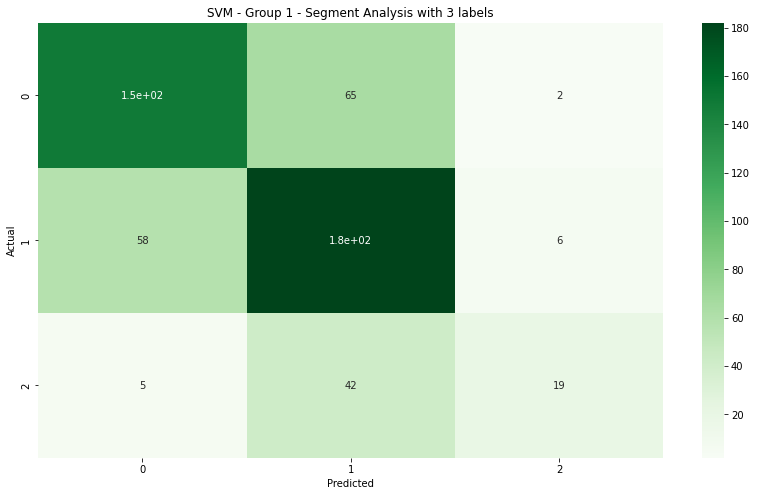

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6447374331336565; Accuracy score = 0.6493506493506493 ; Precisison Score = 0.6444213681055786; Recall score = 0.6493506493506493


 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.67      0.67       189
           1       0.65      0.69      0.67       232
           2       0.50      0.32      0.39        41

    accuracy                           0.65       462
   macro avg       0.61      0.56      0.58       462
weighted avg       0.64      0.65      0.64       462



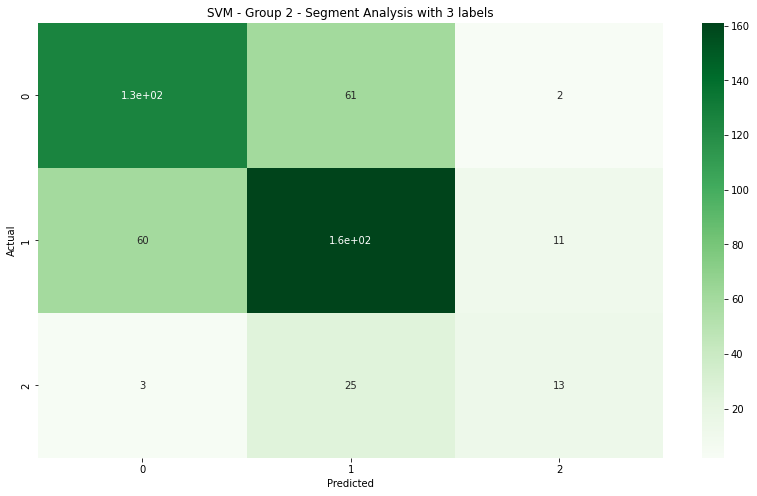

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7100815571640522; Accuracy score = 0.7272727272727273 ; Precisison Score = 0.8070440475132558; Recall score = 0.7272727272727273


 Aggregate report 
               precision    recall  f1-score   support

           0       0.88      0.76      0.82        38
           1       1.00      0.20      0.33        10
           2       0.55      0.94      0.69        18

    accuracy                           0.73        66
   macro avg       0.81      0.64      0.61        66
weighted avg       0.81      0.73      0.71        66



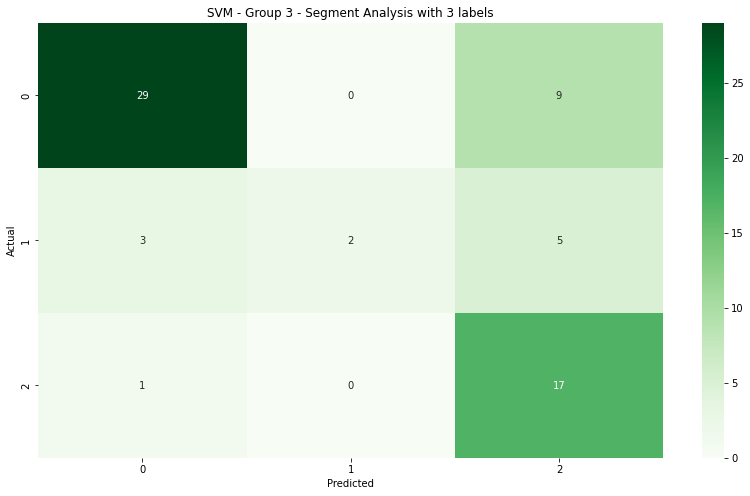

In [312]:
lst_label_np = [label_merged_np, label_merged_non_noisy_np, label_merged_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_mergedlabels_df, standardized_mergedlabels_non_noisy_df, standardized_mergedlabels_noisy_df]
X_test_list = [None,None,None]
kernel = ['rbf', 'rbf', 'linear']
c = [10, 10, 0.1]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma='scale', C=c[i])
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1} - Segment Analysis with 3 labels", actual, predicted, ['0', '1', '2'])

***Result of merging labels and having only 3 labels: 0, 1, 2*** 

There seem to be improvements in terms of accuracy and f1 one scores in the above SVM graphs after merging the labels as can be observed above.

- The model does considerably better in Groups 1 and 2 for the middle level as we can notice a much darker shade of green in the middle compared to the earlier SVM graphs that had 4 labels.
- The model continues to perform considerably better for extreme classes in Group 3.

#### Parent Analysis with merged labels and having only 3 labels



 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.68      0.65        66
           1       0.59      0.69      0.64        91
           2       0.67      0.29      0.41        41

    accuracy                           0.61       198
   macro avg       0.62      0.56      0.56       198
weighted avg       0.61      0.61      0.59       198



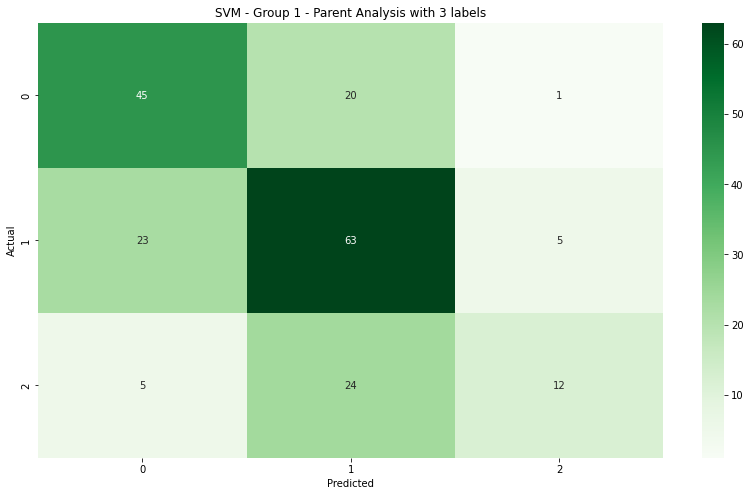



 Aggregate report 
               precision    recall  f1-score   support

           0       0.50      0.51      0.50        51
           1       0.59      0.73      0.66        90
           2       0.69      0.26      0.37        35

    accuracy                           0.57       176
   macro avg       0.60      0.50      0.51       176
weighted avg       0.59      0.57      0.56       176



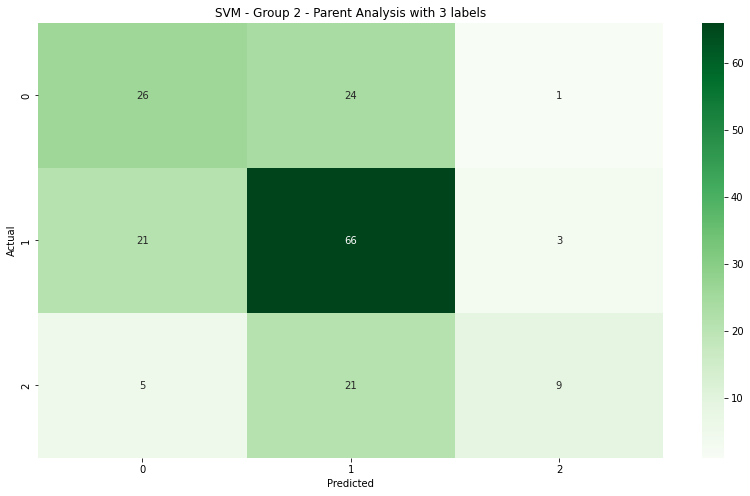



 Aggregate report 
               precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.50      0.12      0.20         8
           2       0.68      0.81      0.74        16

    accuracy                           0.68        44
   macro avg       0.63      0.58      0.56        44
weighted avg       0.66      0.68      0.64        44



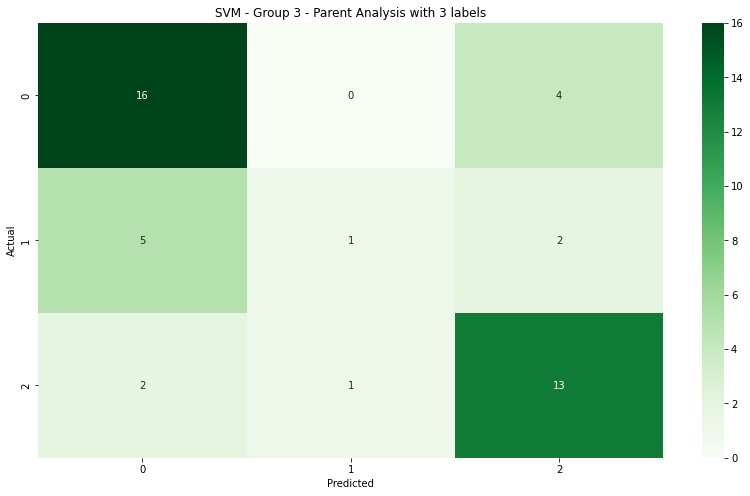

In [314]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non noisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1} - Parent Analysis with 3 labels", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2'])

***Result of merging labels and having only 3 labels: 0, 1, 2 for Parent Analysis*** 

There seem to be improvements in terms of accuracy and f1 one scores in the above after merging the labels as can be observed by the SVM Graphs above.

- The model does considerably better in Groups 1 and 2 for the middle level as we can notice a much darker shade of green in the middle compared to the earlier SVM graphs that had 4 labels.
- The model continues to perform considerably better for extreme classes in Group 3.

### Try balancing levels with 4 classes
- All our labels have a different number of data points associated to them
- In the following code blocks, we resample and allocate all our labels the same number of data points
- This is done largely to avoid sample size biases that might have occurred in the code blocks above.

In [315]:
from sklearn.utils import resample

In [316]:
standardized_aggression_df

,analyse_harmonics,get_max_intensity,analyse_intensity,analyse_pitch,analyse_pitch_range,analyse_shimmer,analyse_jitter,spectral_slope,mean_spectral_rolloff,get_energy,parent_file_train,parent_label_train,segment_label_train,noisy_train
0,-1.229415,0.816248,0.877741,1.42237,0.857657,0.898334,0.355641,-0.331514,0.907009,0.498579,00g8dfgpqpt61,0,0,1
1,-1.369057,0.541133,1.180279,2.008275,0.626936,1.131041,1.008834,-0.322634,0.438397,1.124945,00g8dfgpqpt62,0,0,1
2,-1.194428,1.078107,1.085473,1.8399,0.79798,1.090856,0.310873,-0.620007,0.086267,0.898132,00g8dfgpqpt63,0,0,1
3,-0.570238,-0.770265,-0.652971,1.451482,0.250161,1.114803,0.136983,0.592854,0.016588,-0.582963,01avx2fm1t961,3,3,1
4,-0.770635,-1.140454,-1.310001,1.620578,0.873807,0.829075,0.810602,0.672384,0.279838,-0.674388,01avx2fm1t961,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2105,-0.323659,-0.014225,-0.292555,-0.274583,0.202622,0.987592,-0.006539,0.479082,-0.465383,-0.480872,xdz15thrnem51,2,1,0
2106,0.053725,0.711694,0.719834,0.365542,-0.350018,-0.25594,-0.565074,-0.215352,-0.424726,0.260425,xdz15thrnem51,2,2,0
2107,-0.589685,0.09044,-0.028897,-0.329049,0.642715,0.087973,0.070198,0.395726,-0.508895,-0.37301,xdz15thrnem51,2,1,0
2108,0.508124,0.954183,0.938286,0.665189,0.878313,-0.251261,-0.670125,-0.523881,-0.187419,0.608156,xdz15thrnem51,2,2,0


In [317]:
#check initial size
print(standardized_aggression_df.shape)

(2110, 14)


In [318]:
# Separate classes
level0 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 0]
level1 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 1]
level2 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 2]
level3 = standardized_aggression_df.loc[standardized_aggression_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(915, 14)
(612, 14)
(364, 14)
(219, 14)


In [319]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=600)

#level1 is close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=600)

#Upsample 3 class
level3 = resample(level3, replace=True, n_samples=600)

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_aggression_df_balanced = pd.concat([level0, level1, level2, level3])

(600, 14)
(612, 14)
(600, 14)
(600, 14)


Verify that they have been balanced

In [320]:
print(standardized_aggression_df_balanced.shape)

(2412, 14)


In [321]:
level0 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 0]
level1 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 1]
level2 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 2]
level3 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent balance

level0 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 0]
level1 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 1]
level2 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 2]
level3 = standardized_aggression_df_balanced.loc[standardized_aggression_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(600, 14)
(612, 14)
(600, 14)
(600, 14)
(350, 14)
(435, 14)
(560, 14)
(1067, 14)


Now we do the same for the remaining two groups, we start with `non noisy`

In [322]:
print(standardized_non_noisy_df.shape)

(1848, 14)


In [323]:
# Separate classes
level0 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 0]
level1 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 1]
level2 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 2]
level3 = standardized_non_noisy_df.loc[standardized_non_noisy_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(778, 14)
(593, 14)
(331, 14)
(146, 14)


In [324]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=600)

#level1 is close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=600)

#Upsample 3 class
level3 = resample(level3, replace=True, n_samples=600)

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_non_noisy_df_balanced = pd.concat([level0, level1, level2, level3])

(600, 14)
(593, 14)
(600, 14)
(600, 14)


In [325]:
print(standardized_non_noisy_df_balanced.shape)

(2393, 14)


In [326]:
level0 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 2]
level3 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent label balance

level0 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 2]
level3 = standardized_non_noisy_df_balanced.loc[standardized_non_noisy_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(600, 14)
(593, 14)
(600, 14)
(600, 14)
(312, 14)
(437, 14)
(547, 14)
(1097, 14)


Lastly, we do the same for our last group: `noisy`

In [327]:
print(standardized_noisy_df.shape)

(262, 14)


In [328]:
# Separate classes
level0 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 0]
level1 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 1]
level2 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 2]
level3 = standardized_noisy_df.loc[standardized_noisy_df['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(137, 14)
(19, 14)
(33, 14)
(73, 14)


In [329]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=75)

#Upsample 2 class
level1 = resample(level1, replace=True, n_samples=75)

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=75)

#level3 close enough

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

# Combine
standardized_noisy_df_balanced = pd.concat([level0, level1, level2, level3])

(75, 14)
(75, 14)
(75, 14)
(73, 14)


Verify

In [330]:
print(standardized_noisy_df_balanced.shape)

(298, 14)


In [331]:
level0 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 2]
level3 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['segment_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

#check parent balance 

level0 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 2]
level3 = standardized_noisy_df_balanced.loc[standardized_noisy_df_balanced['parent_label_train'] == 3]

print(level0.shape)
print(level1.shape)
print(level2.shape)
print(level3.shape)

(75, 14)
(75, 14)
(75, 14)
(73, 14)
(65, 14)
(54, 14)
(35, 14)
(144, 14)


All parents are now more unbalanced, but this should not matter because we are not training on them

We will now rebuild the SVM models after having resampled the data above.

In [332]:
data_balanced_np = standardized_aggression_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_np = standardized_aggression_df_balanced['segment_label_train'].to_numpy()
label_balanced_np=label_balanced_np.astype('int')

data_balanced_non_noisy_np = standardized_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_non_noisy_np = standardized_non_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_non_noisy_np=label_balanced_non_noisy_np.astype('int')

data_balanced_noisy_np = standardized_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_noisy_np = standardized_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_noisy_np=label_balanced_noisy_np.astype('int')

C:\Users\samee\AppData\Local\Temp\ipykernel_8920\917994061.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_np = standardized_aggression_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\917994061.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_non_noisy_np = standardized_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\917994061.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_noisy_np = standardized_noisy_df_balanced.drop(["parent_file_train

In [313]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [1000, 10000,100000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_balanced_np, label_balanced_np, quick_parameters)

{'C': 100000, 'gamma': 'auto', 'kernel': 'rbf'}


In [ ]:
quick_parameters = {'C': [100, 1000, 10000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
hyperparameter_tuning(svc, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)

In [ ]:
#up to 10,000 was tested, but it takes a very long time to run, so we dropped it to test the degrees
quick_parameters = {'C': [ 100, 1000], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [2,3,4]}
hyperparameter_tuning(svc, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code blocks take a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below:***

- Group 1: {'C': 100000, 'gamma': 'auto', 'kernel': 'rbf'}
- Group 2: {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
- Group 3: {'C': 1000, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}

#### SVM - Segment Analysis after resampling data

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6633769192444094; Accuracy score = 0.6749585406301825 ; Precisison Score = 0.659779770785611; Recall score = 0.6749585406301825


 Aggregate report 
               precision    recall  f1-score   support

           0       0.54      0.58      0.56       146
           1       0.52      0.38      0.44       156
           2       0.72      0.77      0.74       141
           3       0.85      0.96      0.90       160

    accuracy                           0.67       603
   macro avg       0.66      0.67      0.66       603
weighted avg       0.66      0.67      0.66       603



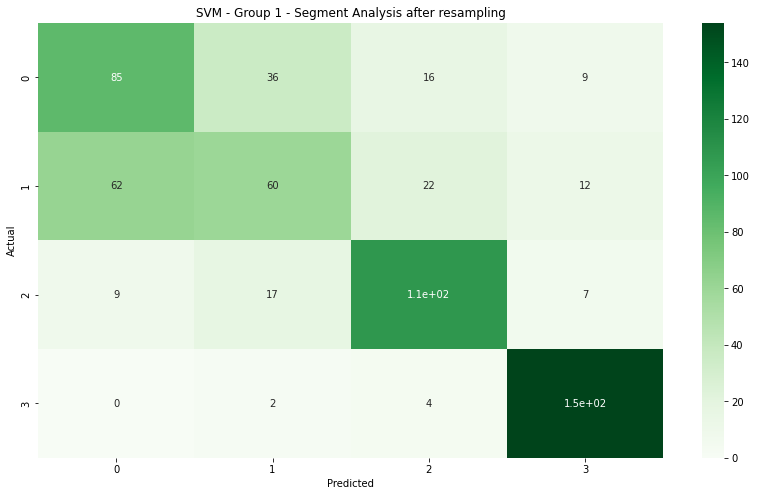

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7221365965571365; Accuracy score = 0.7262103505843072 ; Precisison Score = 0.7210704788426785; Recall score = 0.7262103505843072


 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.57      0.60       163
           1       0.53      0.51      0.52       127
           2       0.74      0.85      0.79       157
           3       0.94      0.95      0.94       152

    accuracy                           0.73       599
   macro avg       0.71      0.72      0.72       599
weighted avg       0.72      0.73      0.72       599



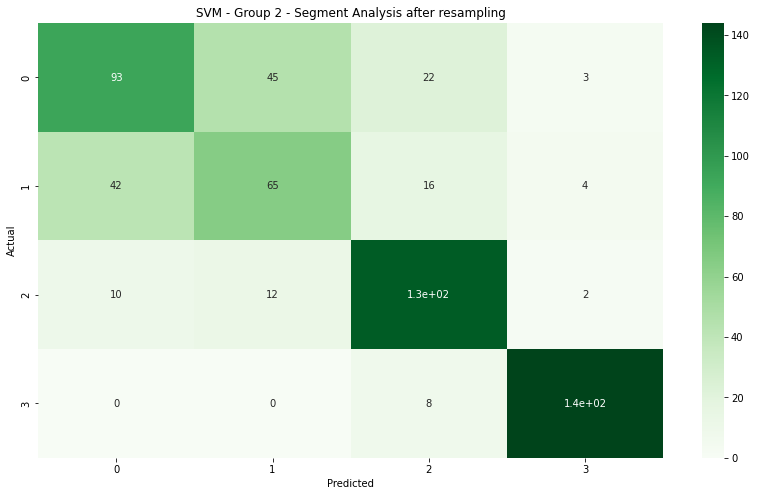

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6681102756892231; Accuracy score = 0.6666666666666666 ; Precisison Score = 0.6737516339869281; Recall score = 0.6666666666666666


 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.76      0.72      0.74        18
           2       0.65      0.72      0.68        18
           3       0.72      0.62      0.67        21

    accuracy                           0.67        75
   macro avg       0.67      0.67      0.67        75
weighted avg       0.67      0.67      0.67        75



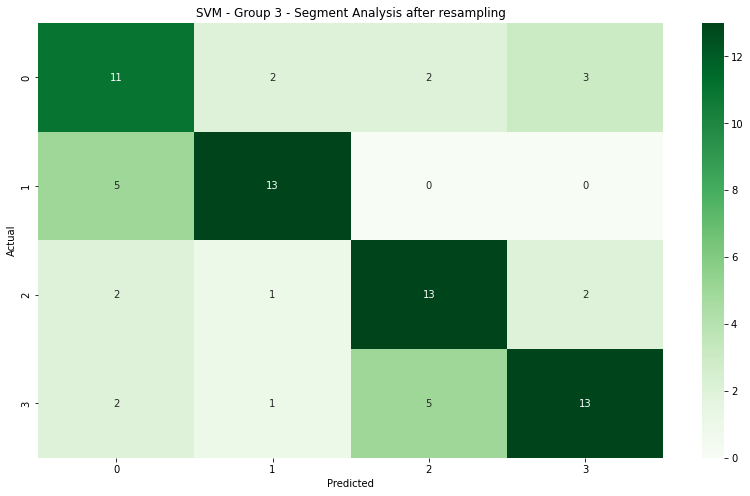

In [334]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
kernel = ['rbf','rbf','poly']
gamma = ['auto', 'scale', 'auto']
c = [100000, 1000, 1000]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma=gamma[i], C=c[i], degree= 3)
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1} - Segment Analysis after resampling", actual, predicted, ['0', '1', '2', '3'])

#### SVM - Parent Analysis after resampling data



 Aggregate report 
               precision    recall  f1-score   support

           0       0.58      0.52      0.55        58
           1       0.60      0.47      0.53        53
           2       0.65      0.76      0.70        41
           3       0.70      0.84      0.76        50

    accuracy                           0.63       202
   macro avg       0.63      0.65      0.63       202
weighted avg       0.63      0.63      0.63       202



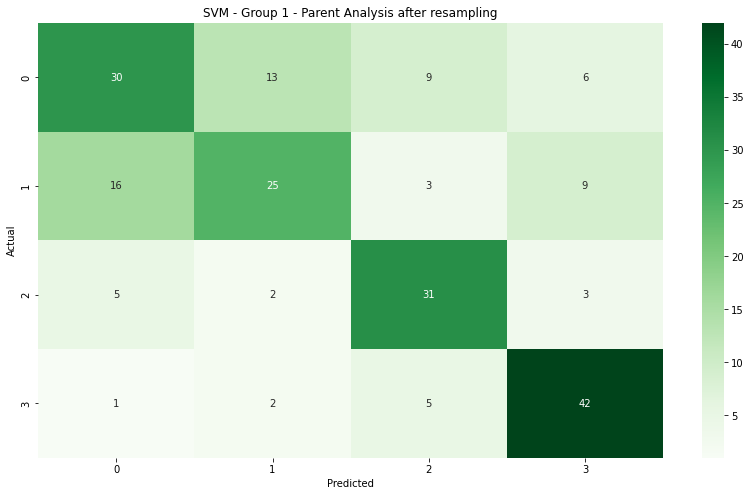



 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.45      0.51        47
           1       0.45      0.51      0.48        39
           2       0.60      0.73      0.66        45
           3       0.87      0.80      0.84        41

    accuracy                           0.62       172
   macro avg       0.63      0.62      0.62       172
weighted avg       0.63      0.62      0.62       172



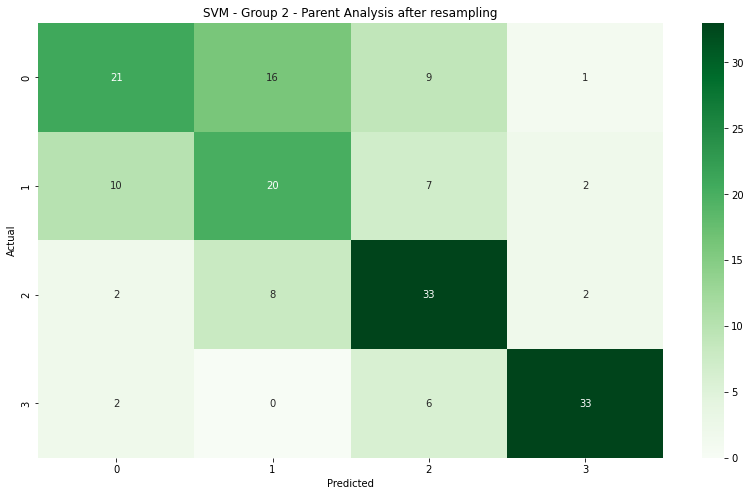



 Aggregate report 
               precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.62      0.71      0.67         7
           2       0.12      0.33      0.18         3
           3       0.73      0.57      0.64        14

    accuracy                           0.57        37
   macro avg       0.54      0.54      0.52        37
weighted avg       0.65      0.57      0.60        37



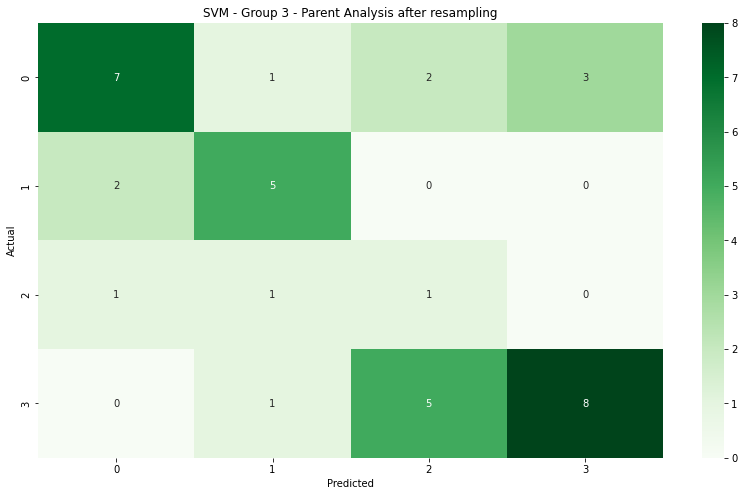

In [336]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1} - Parent Analysis after resampling", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

#### Results after resampling data

- Groups 1 and 2 have about 5-10% increase in terms of accuracy in both the parent and segment analysis.
- Group 3 does not have such substantial improvements.

# Data we choose to move forward with

### Test both balancing the data and combining levels 1 and 2
- In the following codeblock we resample the previously created `merged_labels` data.
- Label 2 was merged to label 1 for both parent and segment analysis.
- Label 3 was merged to label 2 for both parent and segment analysis. 

Group 1 - All data

In [337]:
print(standardized_aggression_mergedlabels_df.shape)

(2110, 14)


In [338]:
# Separate classes
level0 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df.loc[standardized_aggression_mergedlabels_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(915, 14)
(976, 14)
(219, 14)


In [339]:
#level0 close enough

#level1 close enough

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=900)

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_aggression_mergedlabels_df_balanced = pd.concat([level0, level1, level2])

(915, 14)
(976, 14)
(900, 14)


In [340]:
print(standardized_aggression_mergedlabels_df_balanced.shape)

(2791, 14)


In [341]:
level0 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 0]
level1 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 1]
level2 = standardized_aggression_mergedlabels_df_balanced.loc[standardized_aggression_mergedlabels_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(915, 14)
(976, 14)
(900, 14)
(536, 14)
(956, 14)
(1299, 14)


Group 2 - Non noisy

In [342]:
print(standardized_mergedlabels_non_noisy_df.shape)

(1848, 14)


In [343]:
# Separate classes
level0 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df.loc[standardized_mergedlabels_non_noisy_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(778, 14)
(924, 14)
(146, 14)


In [344]:
#level0 close enough

#level1 close enough
# Downsample 0 class
level1 = resample(level1, replace=False,n_samples=775)

#Upsample 2 class
level2 = resample(level2, replace=True, n_samples=775)

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_mergedlabels_non_noisy_df_balanced = pd.concat([level0, level1, level2])

(778, 14)
(775, 14)
(775, 14)


In [345]:
print(standardized_mergedlabels_non_noisy_df_balanced.shape)

(2328, 14)


In [346]:
level0 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_mergedlabels_non_noisy_df_balanced.loc[standardized_mergedlabels_non_noisy_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(778, 14)
(775, 14)
(775, 14)
(418, 14)
(806, 14)
(1104, 14)


Group 3 - Noisy

In [347]:
print(standardized_mergedlabels_noisy_df.shape)

(262, 14)


In [348]:
# Separate classes
level0 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df.loc[standardized_mergedlabels_noisy_df['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(137, 14)
(52, 14)
(73, 14)


In [349]:
# Downsample 0 class
level0 = resample(level0, replace=False,n_samples=75)

#Upsample 2 class
level1 = resample(level1, replace=True, n_samples=75)

#level3 is close enough

print(level0.shape)
print(level1.shape)
print(level2.shape)

# Combine
standardized_mergedlabels_noisy_df_balanced = pd.concat([level0, level1, level2])

(75, 14)
(75, 14)
(73, 14)


In [350]:
print(standardized_mergedlabels_noisy_df_balanced.shape)

(223, 14)


In [351]:
level0 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['segment_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

#check parent label balance

level0 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 0]
level1 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 1]
level2 = standardized_mergedlabels_noisy_df_balanced.loc[standardized_mergedlabels_noisy_df_balanced['parent_label_train'] == 2]

print(level0.shape)
print(level1.shape)
print(level2.shape)

(75, 14)
(75, 14)
(73, 14)
(67, 14)
(45, 14)
(111, 14)


Rebuild the svm models with the updated resampled data and merged labels

In [352]:
data_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_np=label_balanced_merged_np.astype('int')

data_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_non_noisy_np=label_balanced_merged_non_noisy_np.astype('int')

data_balanced_merged_noisy_np = standardized_mergedlabels_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_balanced_merged_noisy_np = standardized_mergedlabels_noisy_df_balanced['segment_label_train'].to_numpy()
label_balanced_merged_noisy_np=label_balanced_merged_noisy_np.astype('int')

C:\Users\samee\AppData\Local\Temp\ipykernel_8920\4173322112.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_np = standardized_aggression_mergedlabels_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\4173322112.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_non_noisy_np = standardized_mergedlabels_non_noisy_df_balanced.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\4173322112.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_balanced_merged_noisy_np = stand

In [286]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'C': [0.01, 0.1, 1, 10], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_balanced_merged_np, label_balanced_merged_np, quick_parameters)
hyperparameter_tuning(svc, data_balanced_merged_non_noisy_np, label_balanced_merged_non_noisy_np, quick_parameters)
hyperparameter_tuning(svc, data_balanced_merged_noisy_np, label_balanced_merged_noisy_np, quick_parameters)

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}


***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below:***

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

#### SVM - Segment Analysis with merged labels and resampled data 

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6963640242780943; Accuracy score = 0.6991404011461319 ; Precisison Score = 0.695140151987243; Recall score = 0.6991404011461319


 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.63      0.65       226
           1       0.62      0.61      0.61       254
           2       0.80      0.88      0.84       218

    accuracy                           0.70       698
   macro avg       0.70      0.71      0.70       698
weighted avg       0.70      0.70      0.70       698



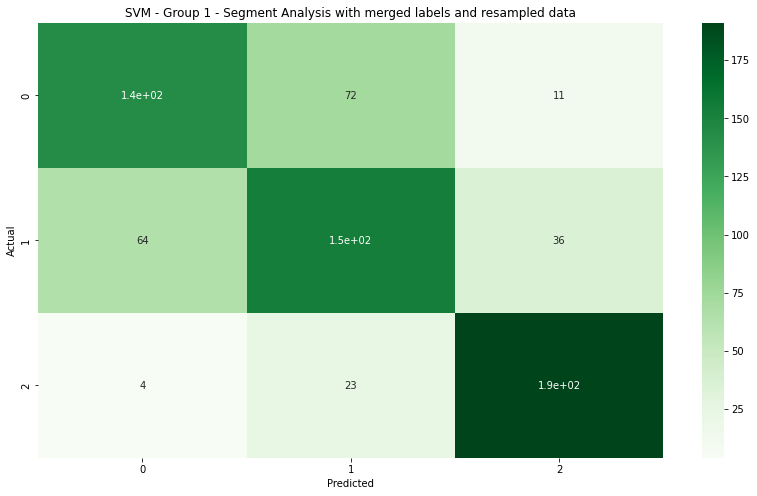

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7344613471211773; Accuracy score = 0.738831615120275 ; Precisison Score = 0.7327936585333079; Recall score = 0.738831615120275


 Aggregate report 
               precision    recall  f1-score   support

           0       0.72      0.69      0.70       205
           1       0.64      0.60      0.62       187
           2       0.83      0.93      0.88       190

    accuracy                           0.74       582
   macro avg       0.73      0.74      0.73       582
weighted avg       0.73      0.74      0.73       582



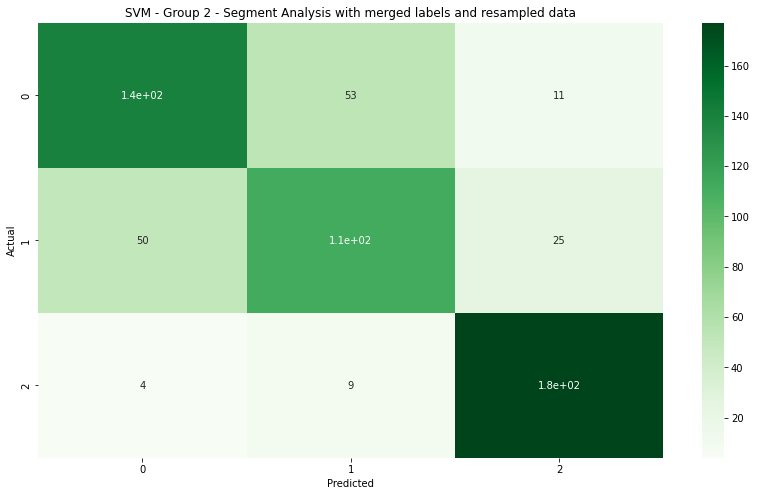

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7283688711801677; Accuracy score = 0.7321428571428571 ; Precisison Score = 0.7378968253968254; Recall score = 0.7321428571428571


 Aggregate report 
               precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.78      0.61      0.68        23
           2       0.70      0.78      0.74        18

    accuracy                           0.73        56
   macro avg       0.73      0.75      0.74        56
weighted avg       0.74      0.73      0.73        56



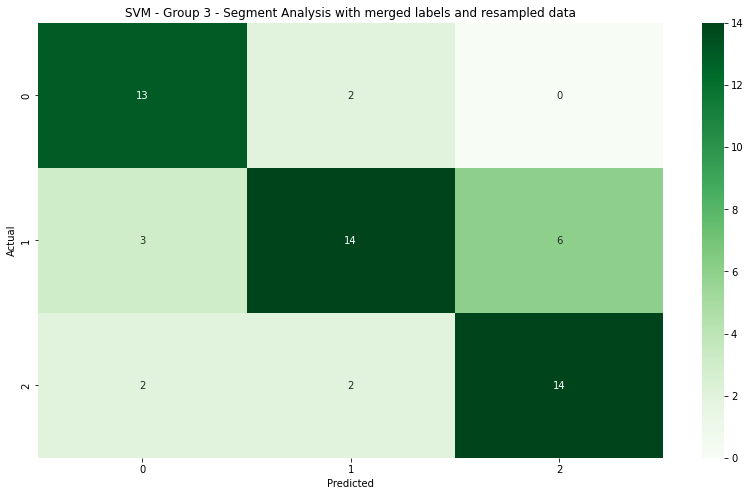

In [353]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_merged_np, label_balanced_merged_non_noisy_np, label_balanced_merged_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_mergedlabels_df_balanced, standardized_mergedlabels_non_noisy_df_balanced, standardized_mergedlabels_noisy_df_balanced]
X_test_list = [None,None,None]
gamma = ['auto', 'scale', 'auto']

for i in range(3):
    svm_model = svm.SVC(kernel='rbf', gamma=gamma[i], C=10)
    actual, predicted, X_test_list[i] = run_model(svm_model, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"SVM - Group {i+1} - Segment Analysis with merged labels and resampled data", actual, predicted, ['0', '1', '2'])

#### SVM - Parent Analysis with merged labels and resampled data 



 Aggregate report 
               precision    recall  f1-score   support

           0       0.55      0.59      0.57        64
           1       0.73      0.59      0.65       100
           2       0.61      0.78      0.68        50

    accuracy                           0.64       214
   macro avg       0.63      0.65      0.64       214
weighted avg       0.65      0.64      0.64       214



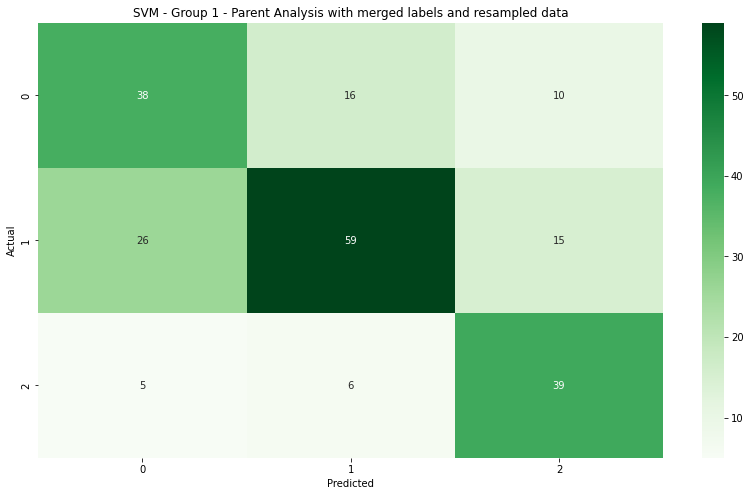



 Aggregate report 
               precision    recall  f1-score   support

           0       0.48      0.58      0.53        52
           1       0.68      0.57      0.62        93
           2       0.61      0.69      0.65        39

    accuracy                           0.60       184
   macro avg       0.59      0.61      0.60       184
weighted avg       0.61      0.60      0.60       184



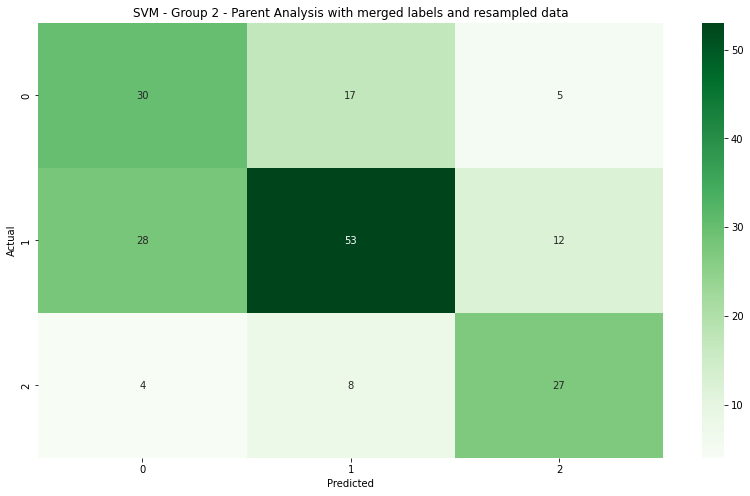



 Aggregate report 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.70      0.64      0.67        11
           2       0.83      0.83      0.83        12

    accuracy                           0.77        35
   macro avg       0.77      0.77      0.77        35
weighted avg       0.77      0.77      0.77        35



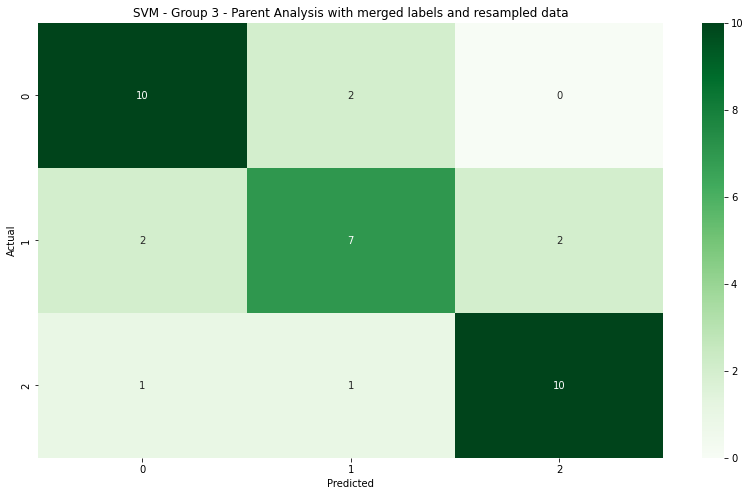

In [355]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group {i+1} - Parent Analysis with merged labels and resampled data", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2']) 

#### EDA: Noisy data - Group 3

Perhaps for Group 3 (noisy) because everything is so loud that we can only seem to get binary classification. Therefore, we will now merge labels for just group 3 (noisy data)
- Label 1 is merged to label 0
- Labels 2 and 3 are combined and re labelled to label 1

In [356]:
standardized_aggression_binary_df = standardized_aggression_df.copy()
standardized_binary_noisy_df = standardized_aggression_binary_df.loc[standardized_aggression_binary_df['noisy_train'] == 1]
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1, 'segment_label_train' ] = 0
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 2, 'segment_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 3, 'segment_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 1, 'parent_label_train'] = 0
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 3, 'parent_label_train'] = 1
standardized_binary_noisy_df.loc[standardized_binary_noisy_df['parent_label_train'] == 2, 'parent_label_train'] = 1
print(standardized_binary_noisy_df['segment_label_train'].unique())
print(standardized_binary_noisy_df['parent_label_train'].unique())

C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2694918186.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1, 'segment_label_train' ] = 0
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2694918186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 2, 'segment_label_train'] = 1
C:\Users\samee\AppData\Local\Temp\ipykernel_8920\2694918186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

[0 1]
[0 1]


In [357]:
data_binary_noisy_np = standardized_binary_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()
label_binary_noisy_np = standardized_binary_noisy_df['segment_label_train'].to_numpy()
label_binary_noisy_np=label_binary_noisy_np.astype('int')

C:\Users\samee\AppData\Local\Temp\ipykernel_8920\524940715.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data_binary_noisy_np = standardized_binary_noisy_df.drop(["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"], 1).to_numpy()


In [296]:
quick_parameters = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100], 'gamma': ['scale','auto'],
                 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

svc = svm.SVC()
hyperparameter_tuning(svc, data_binary_noisy_np, label_binary_noisy_np, quick_parameters)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below:***

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

In [358]:
# Separate classes
level0 = standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 0]
level1 = standardized_binary_noisy_df.loc[standardized_binary_noisy_df['segment_label_train'] == 1]

print(level0.shape)
print(level1.shape)

(156, 14)
(106, 14)


Data is already pretty balanced, no need to resample it

#### SVM - Segment Analysis for Group 3 with 2 labels

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.8506208703577125; Accuracy score = 0.8484848484848485 ; Precisison Score = 0.866750453847228; Recall score = 0.8484848484848485


 Aggregate report 
               precision    recall  f1-score   support

           0       0.94      0.80      0.87        41
           1       0.74      0.92      0.82        25

    accuracy                           0.85        66
   macro avg       0.84      0.86      0.84        66
weighted avg       0.87      0.85      0.85        66



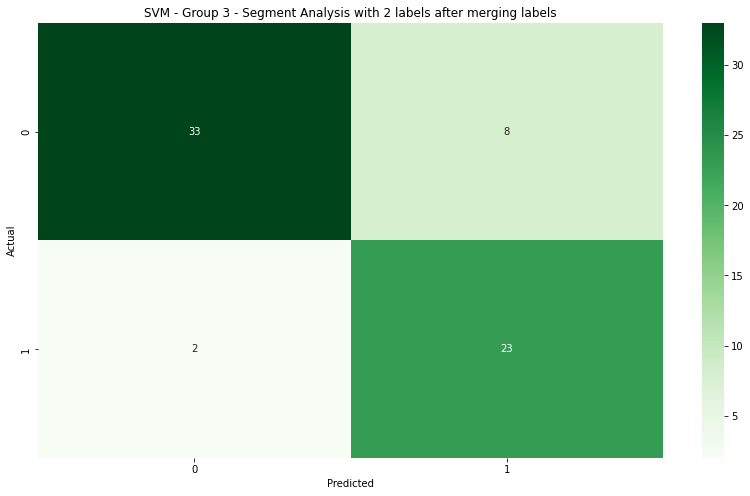

In [359]:
label = 'segment_label_train'
X_test_list = [None]

svm_model = svm.SVC(kernel='linear', gamma='scale', C=0.1)
actual, predicted, X_test_list[0] = run_model(svm_model, standardized_binary_noisy_df,  label_binary_noisy_np,label_name=label)

confusion_matrix_graph(f"SVM - Group 3 - Segment Analysis with 2 labels after merging labels", actual, predicted, ['0', '1'])

#### SVM - Parent Analysis for Group 3 with 2 labels



 Aggregate report 
               precision    recall  f1-score   support

           0       1.00      0.72      0.84        25
           1       0.67      1.00      0.80        14

    accuracy                           0.82        39
   macro avg       0.83      0.86      0.82        39
weighted avg       0.88      0.82      0.82        39



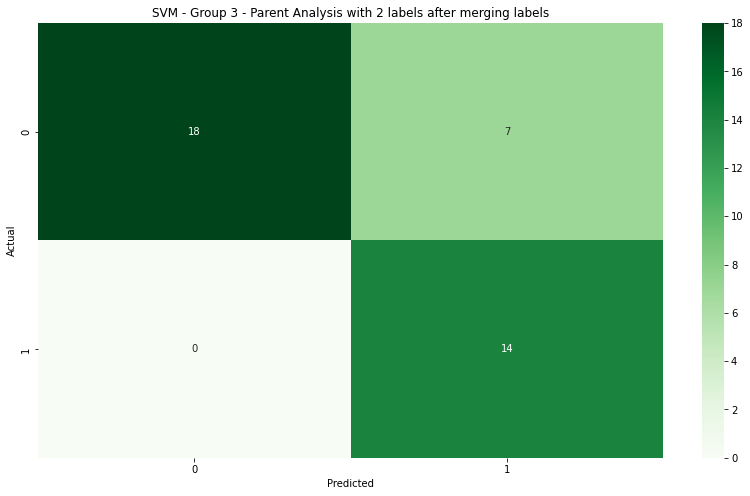

In [360]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non noisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"SVM - Group 3 - Parent Analysis with 2 labels after merging labels", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1'])


#### Results after running the above modified SVM models for Group 3 (noisy):

- For Group 3 (noisy data) middle levels cannot be teased out with the background sound and overlapping voices

## Conclusions based on all the SVM models ran above:

- Combining/merging labels does yields only slightly better models (approx 8%)
- However, merging the lables deviates our focus from our original research question
- Therefore, it is more interesting to classify both noisy and non-noisy with the same levels and without merging the labels.
- ***Hence, we will select the orignal classification of 4 labels with the balanced data, in the all the various models below***

# KNN

In [361]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier()
# knn.fit(X, y)
# KNeighborsClassifier()
k_range = list(range(1, 31))

#### Hyperparameter Tuning for Group 1 (all data) KNN

In [ ]:
# original_parameters = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'gamma': ['scale', 'auto'],
#                    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'degree': [1,2,3,4,5,6]}

quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_np, label_balanced_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


#### Hyperparameter Tuning for Group 2 (non noisy) KNN

In [ ]:
quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


#### Hyperparameter Tuning for Group 3 (noisy) KNN

In [ ]:
#up to 10,000 was tested, but it takes a very long time to run, so we dropped it to test the degrees
quick_parameters = {'n_neighbors':k_range, 'weights': ['uniform','distance'],
                    'metric': ['euclidean', 'manhattan'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                    'leaf_size':k_range}
hyperparameter_tuning(knn, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}


***NOTE: The above code blocks take a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below:***

- Group 1: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
- Group 2: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
- Group 3: {'algorithm': 'auto', 'leaf_size': 1, 'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

#### kNN - Segment Analysis

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6981879518077982; Accuracy score = 0.7097844112769486 ; Precisison Score = 0.6942978899246108; Recall score = 0.7097844112769486


 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.50      0.53       132
           1       0.60      0.49      0.54       156
           2       0.77      0.85      0.80       162
           3       0.82      0.97      0.89       153

    accuracy                           0.71       603
   macro avg       0.69      0.70      0.69       603
weighted avg       0.69      0.71      0.70       603



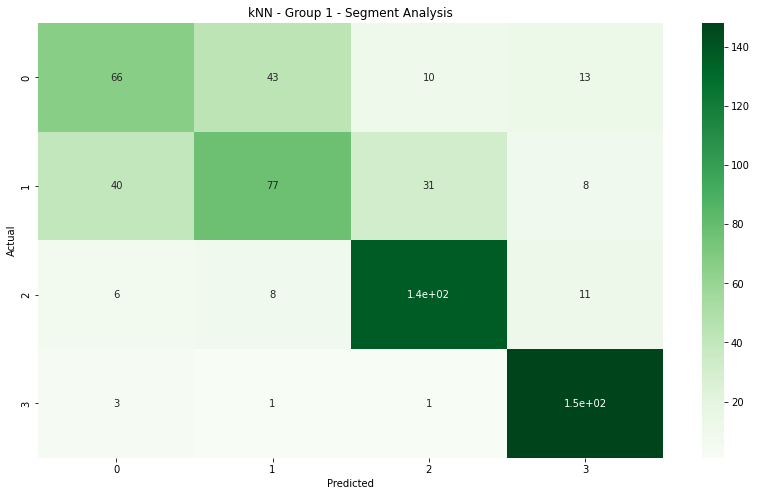

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7209766007016267; Accuracy score = 0.7295492487479132 ; Precisison Score = 0.7169773815504766; Recall score = 0.7295492487479132


 Aggregate report 
               precision    recall  f1-score   support

           0       0.61      0.55      0.58       141
           1       0.59      0.52      0.55       155
           2       0.76      0.86      0.81       163
           3       0.92      1.00      0.96       140

    accuracy                           0.73       599
   macro avg       0.72      0.73      0.72       599
weighted avg       0.72      0.73      0.72       599



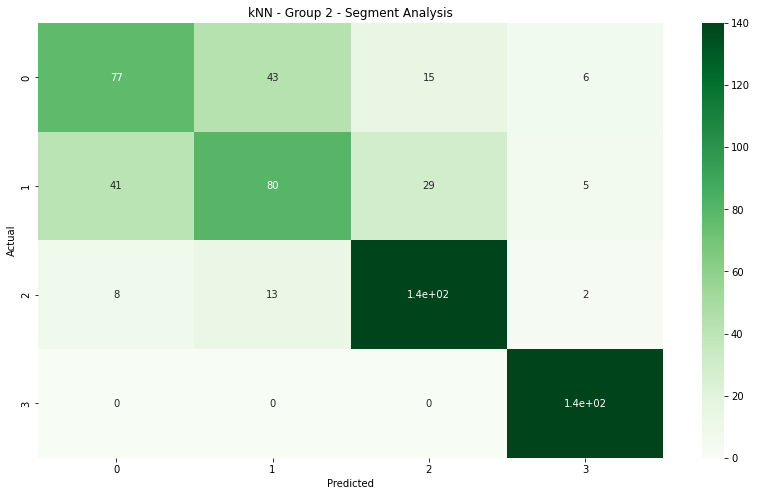

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7300428957506757; Accuracy score = 0.7333333333333333 ; Precisison Score = 0.7538803418803419; Recall score = 0.7333333333333333


 Aggregate report 
               precision    recall  f1-score   support

           0       0.79      0.52      0.63        21
           1       0.93      0.88      0.90        16
           2       0.60      0.92      0.73        13
           3       0.69      0.72      0.71        25

    accuracy                           0.73        75
   macro avg       0.75      0.76      0.74        75
weighted avg       0.75      0.73      0.73        75



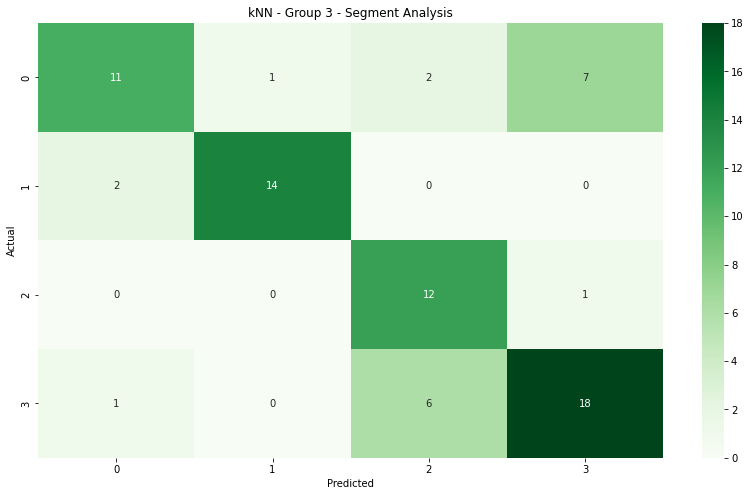

In [362]:
#lst_data_np = [data_np, data_non_noisy_np, data_noisy_np]
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
metric = ['manhattan','manhattan','euclidean']

for i in range(3):
    knn = KNeighborsClassifier(n_neighbors= 1,algorithm='auto',leaf_size= 1, metric= metric[i],weights='uniform')
    actual, predicted, X_test_list[i] = run_model(knn, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"kNN - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

### kNN - Parent Analysis



 Aggregate report 
               precision    recall  f1-score   support

           0       0.69      0.48      0.57        52
           1       0.59      0.55      0.57        47
           2       0.73      0.85      0.79        48
           3       0.71      0.86      0.78        51

    accuracy                           0.69       198
   macro avg       0.68      0.69      0.68       198
weighted avg       0.68      0.69      0.68       198



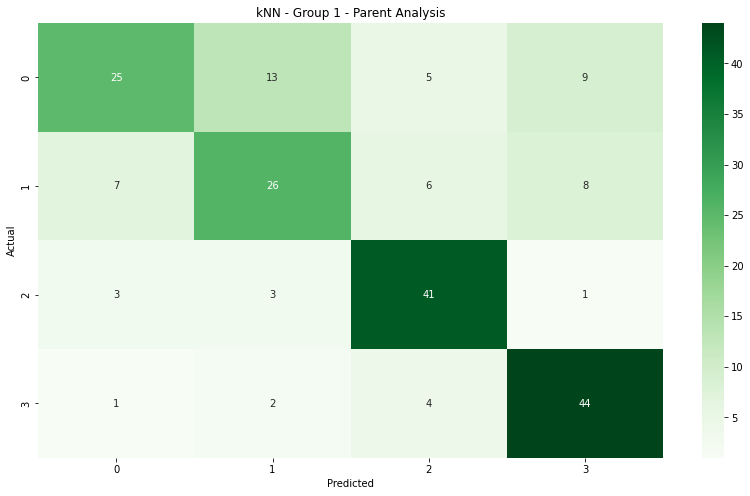



 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.43      0.50        51
           1       0.54      0.52      0.53        48
           2       0.56      0.80      0.66        44
           3       0.78      0.74      0.76        38

    accuracy                           0.61       181
   macro avg       0.62      0.62      0.61       181
weighted avg       0.61      0.61      0.60       181



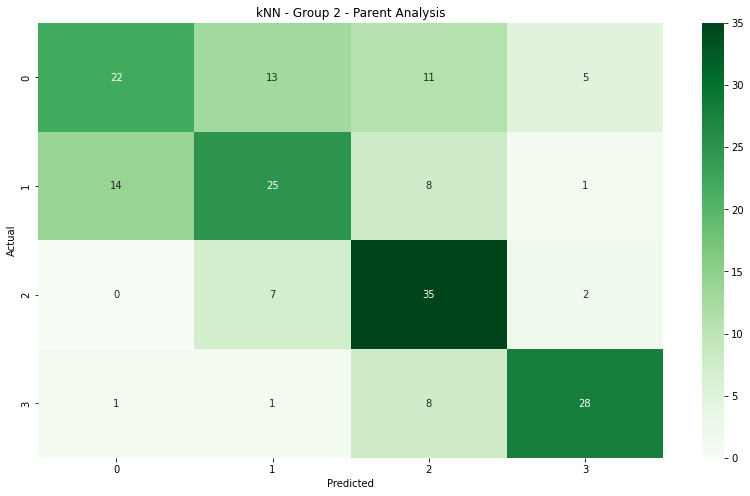



 Aggregate report 
               precision    recall  f1-score   support

           0       0.88      0.54      0.67        13
           1       0.71      0.62      0.67         8
           2       0.29      0.67      0.40         3
           3       0.60      0.69      0.64        13

    accuracy                           0.62        37
   macro avg       0.62      0.63      0.59        37
weighted avg       0.70      0.62      0.64        37



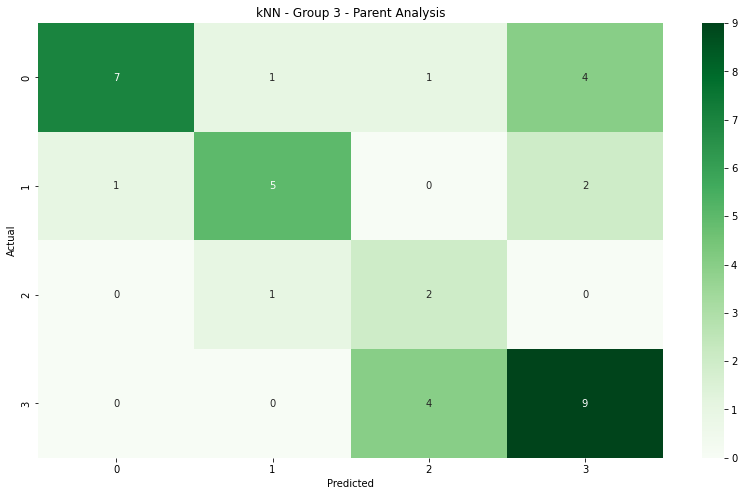

In [363]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"kNN - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])  

# Tree based models

In [364]:
# Load Library
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

### Decision Tree

In [ ]:
quick_parameters = {'criterion' : ['gini', 'entropy'], 'max_depth' : [2,4,6,8,10,12,14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]}

dtree = DecisionTreeClassifier()
hyperparameter_tuning(dtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning(dtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning(dtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below:***

{'criterion': 'entropy', 'max_depth': 30}

{'criterion': 'entropy', 'max_depth': 20}

{'criterion': 'gini', 'max_depth': 18}

#### Decision Tree - Segment Analysis

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6937226027739177; Accuracy score = 0.7048092868988391 ; Precisison Score = 0.6906213856434504; Recall score = 0.7048092868988391


 Aggregate report 
               precision    recall  f1-score   support

           0       0.63      0.54      0.58       141
           1       0.58      0.49      0.53       168
           2       0.74      0.83      0.78       145
           3       0.82      0.98      0.90       149

    accuracy                           0.70       603
   macro avg       0.69      0.71      0.70       603
weighted avg       0.69      0.70      0.69       603



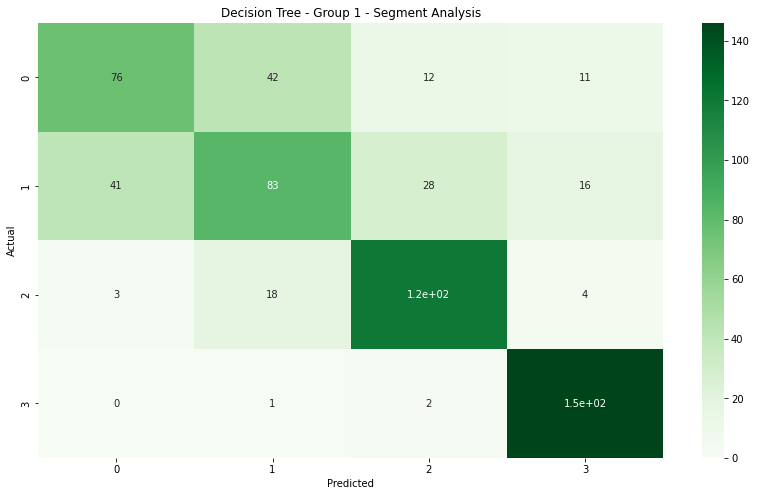

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6416675136904572; Accuracy score = 0.6510851419031719 ; Precisison Score = 0.6358668718558986; Recall score = 0.6510851419031719


 Aggregate report 
               precision    recall  f1-score   support

           0       0.53      0.48      0.50       153
           1       0.46      0.40      0.43       141
           2       0.68      0.75      0.71       150
           3       0.86      0.95      0.91       155

    accuracy                           0.65       599
   macro avg       0.63      0.65      0.64       599
weighted avg       0.64      0.65      0.64       599



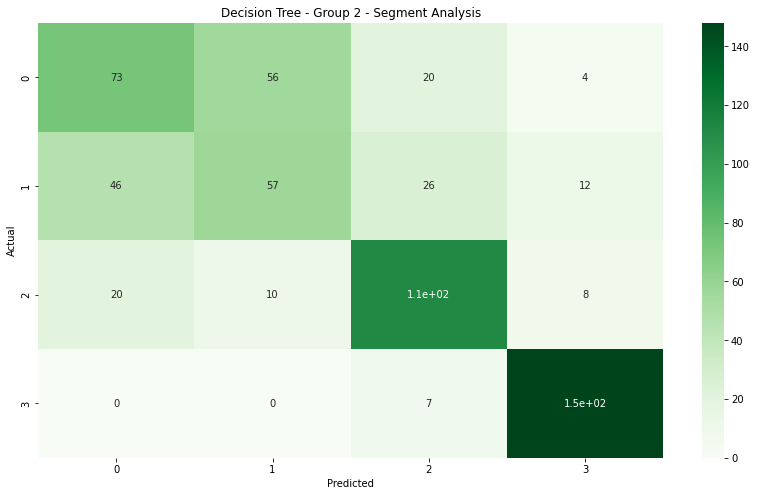

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7960077519379845; Accuracy score = 0.8 ; Precisison Score = 0.7968186209925341; Recall score = 0.8


 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.95      1.00      0.98        21
           2       0.74      0.85      0.79        20
           3       0.73      0.65      0.69        17

    accuracy                           0.80        75
   macro avg       0.79      0.79      0.79        75
weighted avg       0.80      0.80      0.80        75



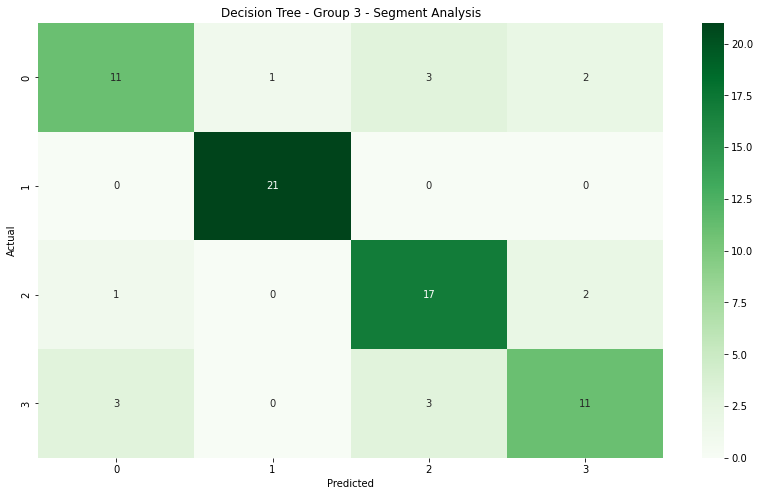

In [365]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
criterion = ['entropy','entropy','gini']
max_depth = [30,20,18]

for i in range(3):
    dtree = DecisionTreeClassifier(criterion=criterion[i], max_depth=max_depth[i])
    actual, predicted, X_test_list[i] = run_model(dtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Decision Tree - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Decision Tree - Parent Analysis



 Aggregate report 
               precision    recall  f1-score   support

           0       0.58      0.40      0.47        53
           1       0.50      0.49      0.49        45
           2       0.64      0.68      0.66        50
           3       0.67      0.88      0.76        49

    accuracy                           0.61       197
   macro avg       0.60      0.61      0.60       197
weighted avg       0.60      0.61      0.60       197



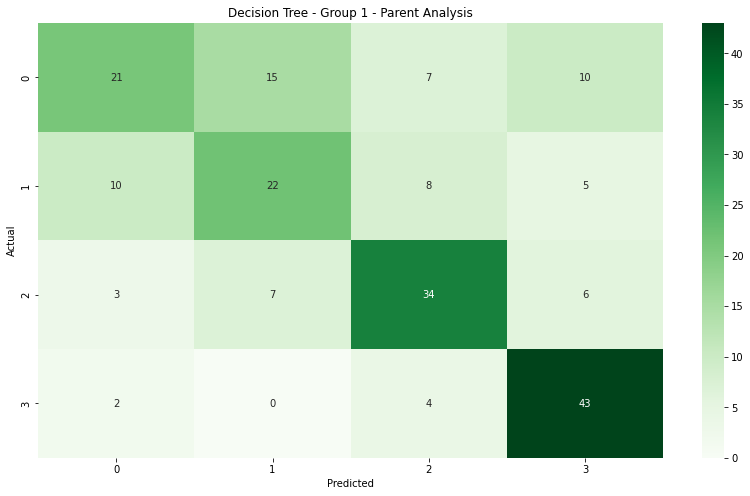



 Aggregate report 
               precision    recall  f1-score   support

           0       0.46      0.30      0.37        43
           1       0.48      0.49      0.48        49
           2       0.54      0.63      0.58        46
           3       0.72      0.83      0.77        41

    accuracy                           0.56       179
   macro avg       0.55      0.56      0.55       179
weighted avg       0.55      0.56      0.55       179



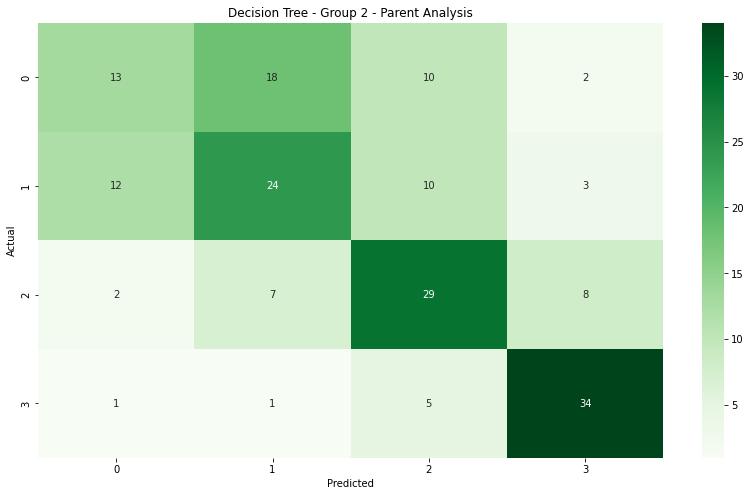



 Aggregate report 
               precision    recall  f1-score   support

           0       0.56      0.45      0.50        11
           1       0.57      0.80      0.67         5
           2       0.25      0.60      0.35         5
           3       0.78      0.44      0.56        16

    accuracy                           0.51        37
   macro avg       0.54      0.57      0.52        37
weighted avg       0.61      0.51      0.53        37



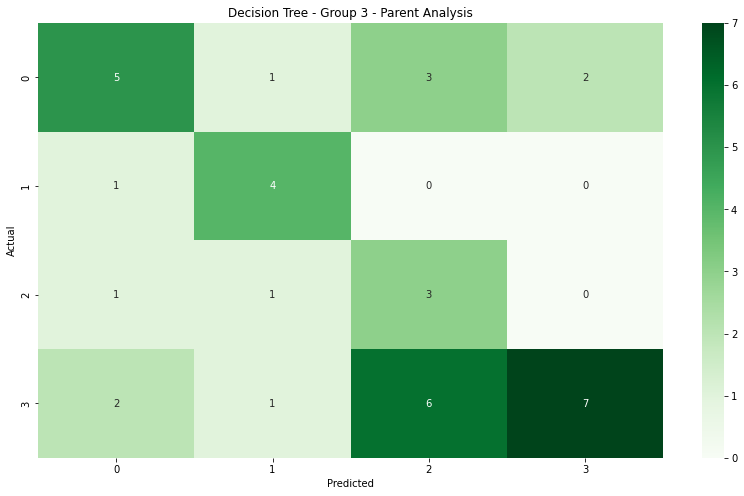

In [366]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Decision Tree - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])


## Random Forest

- `random search` has been used to speed up the grid search (was taking 12h+)

In [367]:
from sklearn.model_selection import RandomizedSearchCV

In [368]:
def hyperparameter_tuning_random(ml_model, data, label, parameters):
    clf = RandomizedSearchCV(ml_model, parameters, n_iter = 50, refit=True, verbose=0, scoring='f1_weighted', n_jobs=-1, error_score='raise')
    clf.fit(data, label)
    print(clf.best_params_)

In [ ]:
quick_parameters = {
  'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
  'max_features' : ['auto', 'sqrt'],
  'max_depth' : [int(x) for x in np.linspace(10, 150, num = 11)],
  'min_samples_split' : [2, 5, 10, 15],
  'min_samples_leaf' : [1, 2, 4],
  'bootstrap' : [True, False],
}

rtree = RandomForestClassifier()
hyperparameter_tuning_random(rtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning_random(rtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning_random(rtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for all three groups:***

Group 1 (all data): {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 122, 'bootstrap': False}

Group 2 (non noisy): {'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 38, 'bootstrap': False}

Group 3 (noisy): {'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}

#### Random Forest Model - Segment Analysis

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7169340164595314; Accuracy score = 0.7197346600331676 ; Precisison Score = 0.7151869570268534; Recall score = 0.7197346600331676


 Aggregate report 
               precision    recall  f1-score   support

           0       0.69      0.66      0.68       157
           1       0.55      0.53      0.54       153
           2       0.78      0.77      0.77       148
           3       0.85      0.93      0.89       145

    accuracy                           0.72       603
   macro avg       0.72      0.72      0.72       603
weighted avg       0.72      0.72      0.72       603



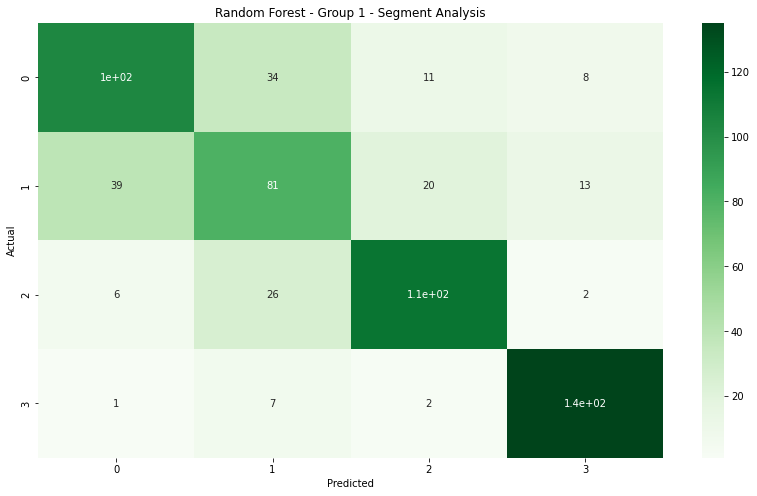

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7248209170106823; Accuracy score = 0.7328881469115192 ; Precisison Score = 0.7220269314483184; Recall score = 0.7328881469115192


 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.60      0.64       154
           1       0.58      0.52      0.55       147
           2       0.75      0.83      0.79       146
           3       0.87      0.99      0.93       152

    accuracy                           0.73       599
   macro avg       0.72      0.73      0.72       599
weighted avg       0.72      0.73      0.72       599



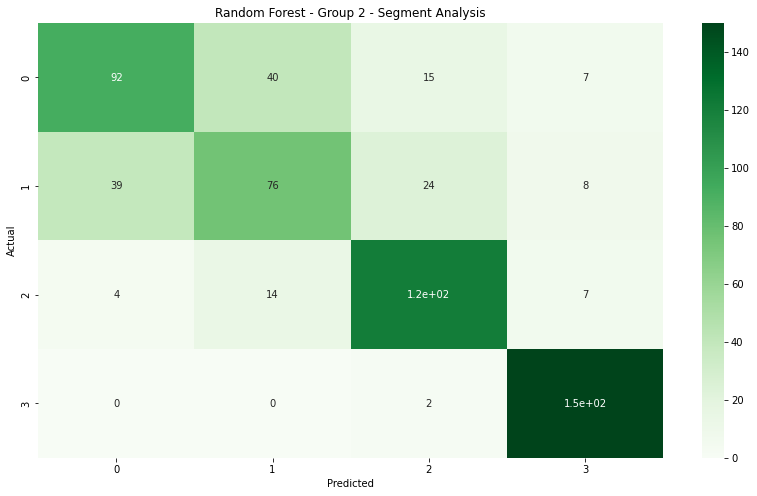

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7983049095607235; Accuracy score = 0.8 ; Precisison Score = 0.8057301587301589; Recall score = 0.8


 Aggregate report 
               precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.94      0.94      0.94        17
           2       0.80      0.70      0.74        23
           3       0.71      0.89      0.79        19

    accuracy                           0.80        75
   macro avg       0.81      0.80      0.80        75
weighted avg       0.81      0.80      0.80        75



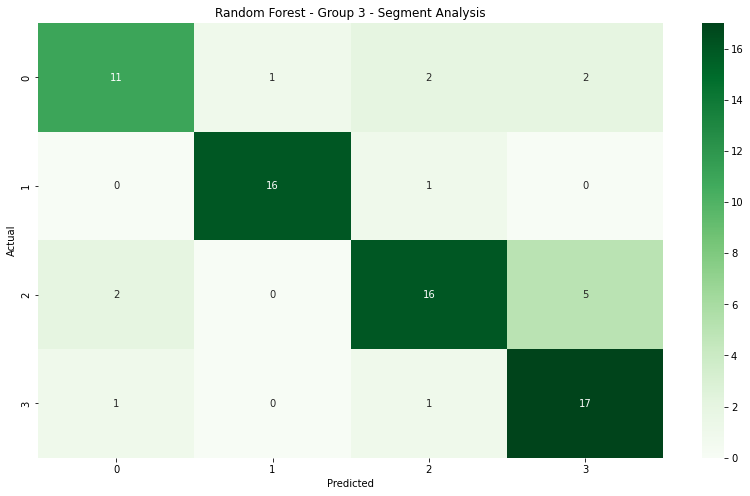

In [369]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
n_estimators = [1600, 1600, 600]
max_features = ['sqrt', 'auto', 'auto']
max_depth = [122, 38, 80]
min_samples_split = [5, 5, 5]
min_samples_leaf = [1, 1, 1]
bootstrap = ['False', ]

for i in range(3):
    rtree = RandomForestClassifier(
      n_estimators = n_estimators[i],
      max_features = max_features[i],
      max_depth = max_depth[i],
      min_samples_split = 5,
      min_samples_leaf = 1,
      bootstrap = 'False'
    )
    actual, predicted, X_test_list[i] = run_model(rtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Random Forest - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Random Forest - Parent Analysis



 Aggregate report 
               precision    recall  f1-score   support

           0       0.68      0.59      0.63        61
           1       0.49      0.43      0.45        47
           2       0.65      0.70      0.67        47
           3       0.71      0.85      0.77        48

    accuracy                           0.64       203
   macro avg       0.63      0.64      0.63       203
weighted avg       0.63      0.64      0.63       203



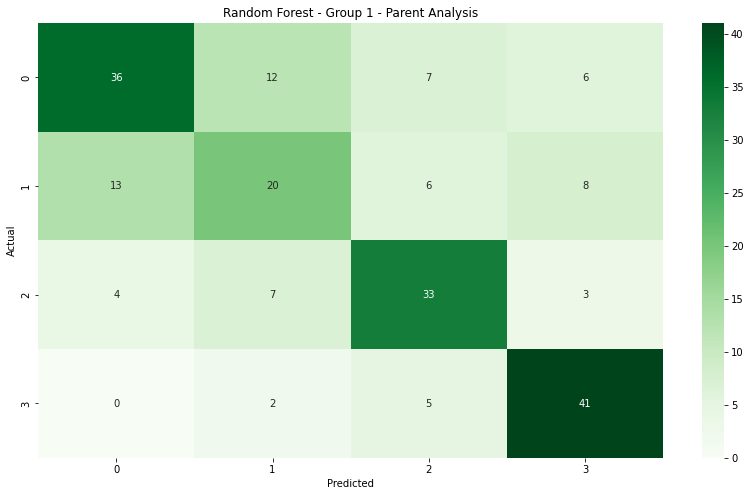



 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.54      0.59        57
           1       0.53      0.50      0.51        42
           2       0.63      0.72      0.67        46
           3       0.72      0.82      0.77        38

    accuracy                           0.63       183
   macro avg       0.63      0.64      0.64       183
weighted avg       0.63      0.63      0.63       183



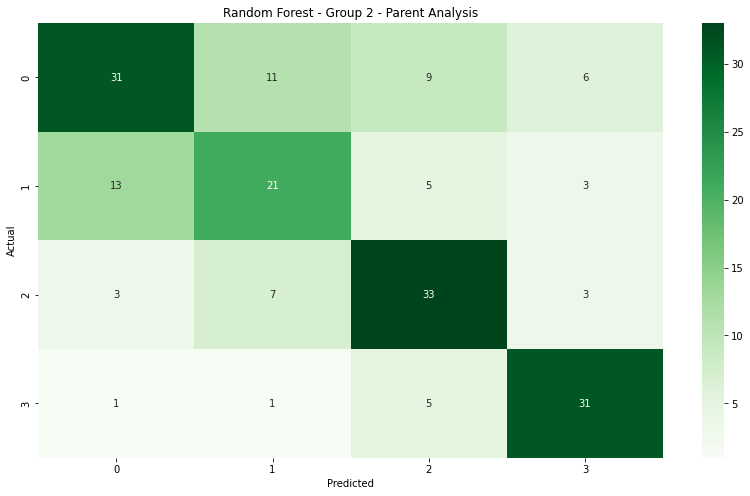



 Aggregate report 
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.83      0.62      0.71         8
           2       0.50      0.67      0.57         6
           3       0.73      0.73      0.73        11

    accuracy                           0.70        33
   macro avg       0.70      0.69      0.69        33
weighted avg       0.72      0.70      0.70        33



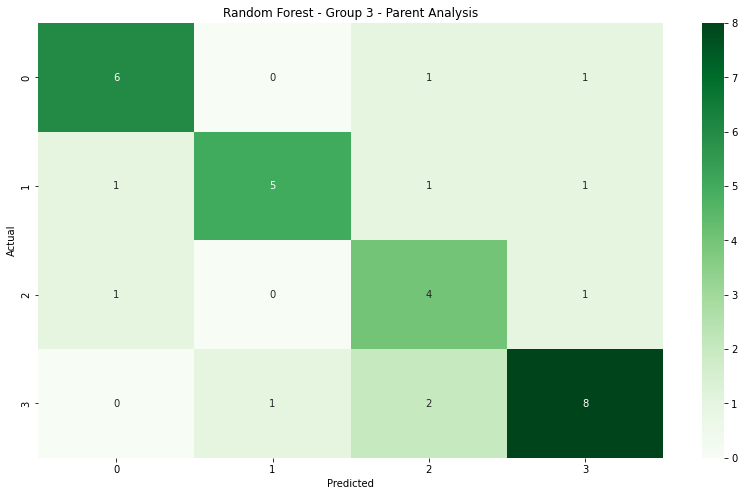

In [370]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Random Forest - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])


## Ada Boost

adaboost with decision tree base

In [ ]:
quick_parameters = {
  'base_estimator' : [dtree],
  'n_estimators' : [10, 20, 50, 100],
  'learning_rate' : [ 0.01, 0.1, 1, 10]
}

adtree = AdaBoostClassifier()
hyperparameter_tuning(adtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning(adtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning(adtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for all three groups:***

Group 1 (all data): {'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 1, 'n_estimators': 50}

Group 2 (non noisy): {'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 1, 'n_estimators': 20}

Group 3 (noisy): {'base_estimator': DecisionTreeClassifier(max_depth=18), 'learning_rate': 0.1, 'n_estimators': 20}

#### Ada Boost with Decision Tree Base - Segment Analysis

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6971828942184894; Accuracy score = 0.7048092868988391 ; Precisison Score = 0.6952420653770724; Recall score = 0.7048092868988391


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.55      0.60       155
           1       0.57      0.51      0.54       152
           2       0.71      0.82      0.76       147
           3       0.85      0.95      0.90       149

    accuracy                           0.70       603
   macro avg       0.70      0.71      0.70       603
weighted avg       0.70      0.70      0.70       603



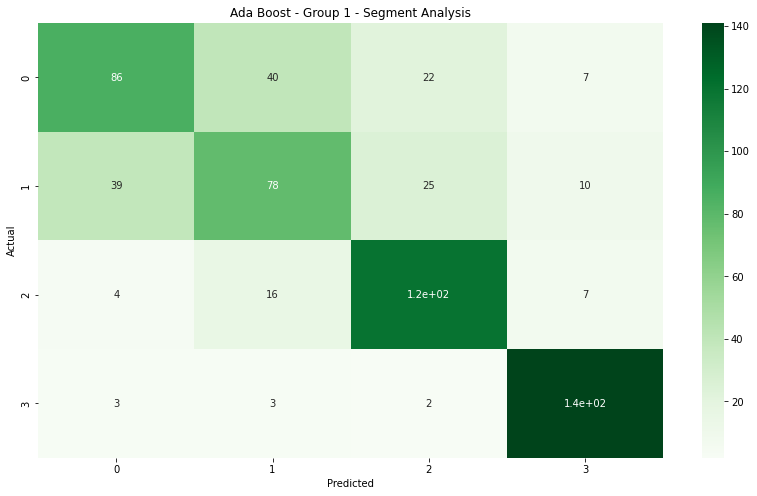

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.6620878003682654; Accuracy score = 0.671118530884808 ; Precisison Score = 0.6622728571819925; Recall score = 0.671118530884808


 Aggregate report 
               precision    recall  f1-score   support

           0       0.51      0.50      0.50       128
           1       0.60      0.46      0.52       173
           2       0.68      0.83      0.75       152
           3       0.85      0.90      0.87       146

    accuracy                           0.67       599
   macro avg       0.66      0.67      0.66       599
weighted avg       0.66      0.67      0.66       599



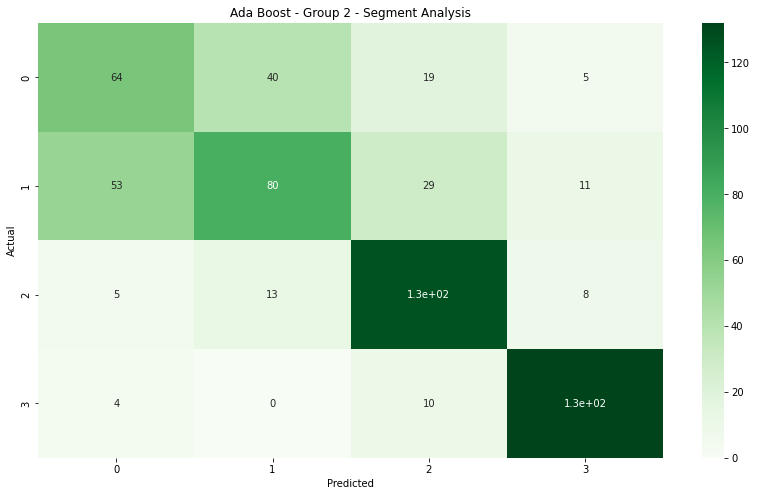

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.787195645306311; Accuracy score = 0.8 ; Precisison Score = 0.8049428571428572; Recall score = 0.8


 Aggregate report 
               precision    recall  f1-score   support

           0       0.86      0.63      0.73        19
           1       0.88      1.00      0.93        21
           2       0.72      1.00      0.84        18
           3       0.75      0.53      0.62        17

    accuracy                           0.80        75
   macro avg       0.80      0.79      0.78        75
weighted avg       0.80      0.80      0.79        75



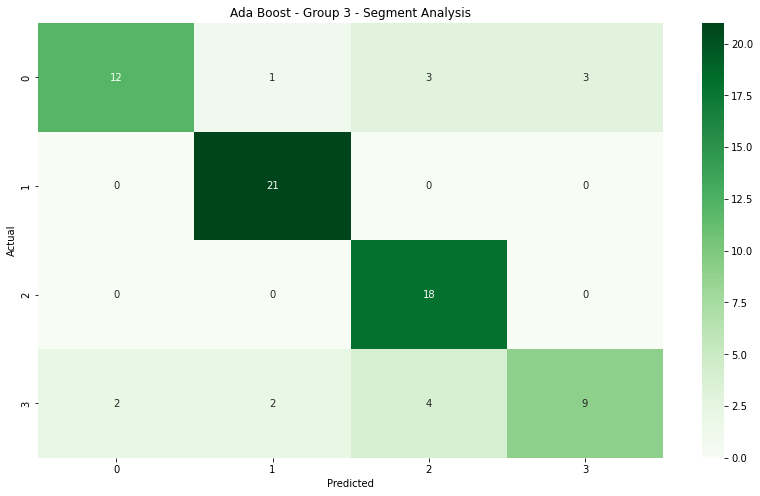

In [371]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
n_estimators = [50, 20, 20]
learning_rate = [1, 1, 0.1]

for i in range(3):
    adtree = AdaBoostClassifier(base_estimator = dtree, n_estimators=n_estimators[i], learning_rate=learning_rate[i])
    actual, predicted, X_test_list[i] = run_model(adtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Ada Boost - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Ada Boost with Decision Tree Base - Parent Analysis



 Aggregate report 
               precision    recall  f1-score   support

           0       0.62      0.46      0.53        57
           1       0.38      0.34      0.36        47
           2       0.51      0.67      0.58        49
           3       0.72      0.78      0.75        50

    accuracy                           0.56       203
   macro avg       0.56      0.56      0.55       203
weighted avg       0.56      0.56      0.56       203



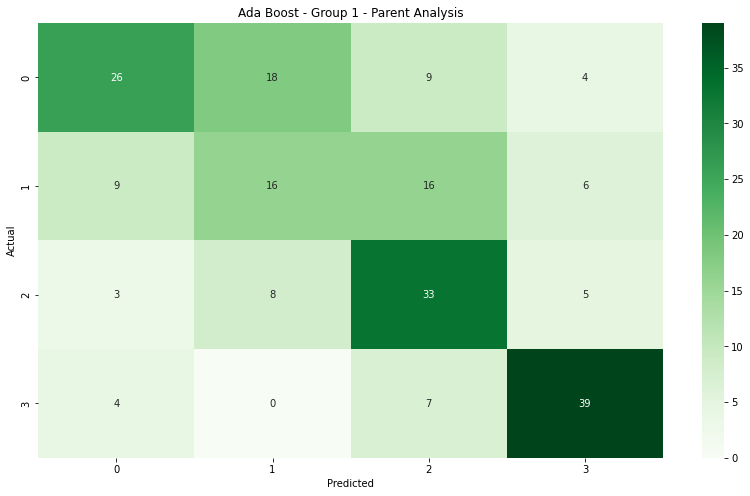



 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.37      0.45        43
           1       0.51      0.51      0.51        53
           2       0.54      0.70      0.61        47
           3       0.74      0.76      0.75        41

    accuracy                           0.58       184
   macro avg       0.59      0.58      0.58       184
weighted avg       0.58      0.58      0.57       184



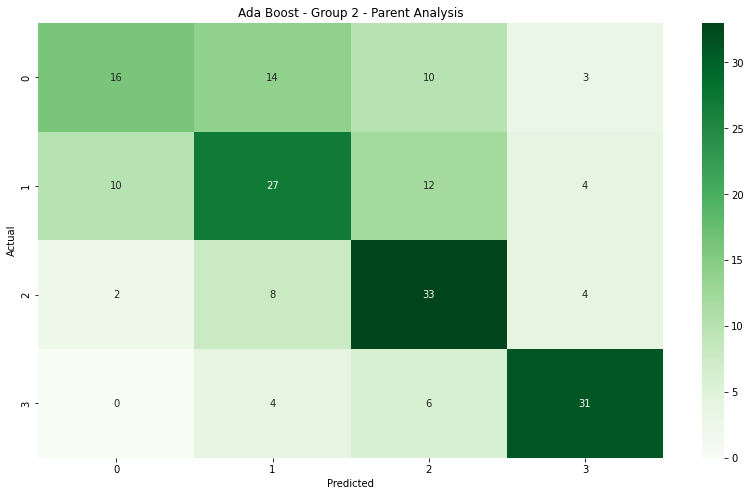



 Aggregate report 
               precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.62      0.83      0.71         6
           2       0.22      0.67      0.33         3
           3       0.80      0.57      0.67        14

    accuracy                           0.60        35
   macro avg       0.60      0.64      0.58        35
weighted avg       0.70      0.60      0.62        35



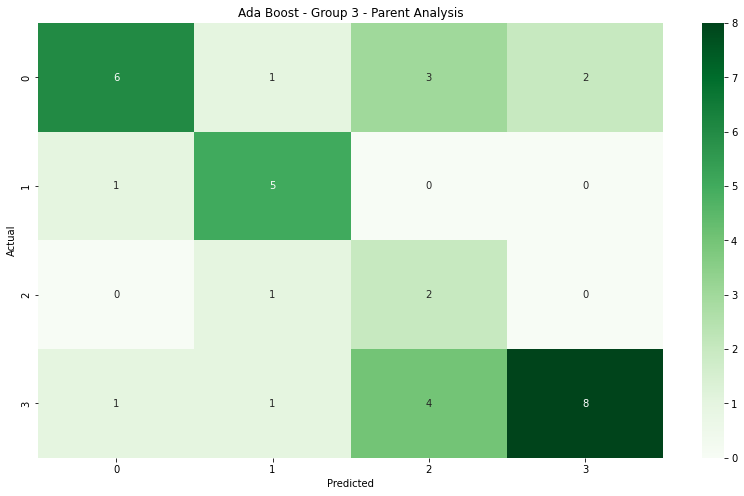

In [373]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Ada Boost - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

## XG Boost

In [ ]:
quick_parameters = {
  'min_child_weight': [1, 5, 10, 15],
  'gamma': [0.5, 1, 1.5, 2, 5],
  'subsample': [0.6, 0.8, 1.0],
  'colsample_bytree': [0.6, 0.8, 1.0],
  'max_depth': [2, 5, 10, 15],
  'alpha' : [0.1, 1, 3, 6],
  'lambda' :  [1, 3, 6],
  'max_delta_step' : [2],
  'objective' : ['reg:squarederror'],
  'eta' :  [ 0.01, 0.1, 1, 10],
  'num_boost_round' : [5]
}

xgtree = XGBClassifier()
hyperparameter_tuning_random(xgtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning_random(xgtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning_random(xgtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for all three groups:***

Group 1 (all data): {'subsample': 1.0, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 5, 'max_depth': 5, 'max_delta_step': 2, 'lambda': 3, 'gamma': 1, 'eta': 1, 'colsample_bytree': 0.8, 'alpha': 0.1}


Group 2 (non noisy): {'subsample': 0.8, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 1, 'max_depth': 10, 'max_delta_step': 2, 'lambda': 1, 'gamma': 1, 'eta': 0.1, 'colsample_bytree': 0.6, 'alpha': 0.1}


Group 3 (noisy): {'subsample': 1.0, 'objective': 'reg:squarederror', 'num_boost_round': 5, 'min_child_weight': 1, 'max_depth': 5, 'max_delta_step': 2, 'lambda': 6, 'gamma': 0.5, 'eta': 0.1, 'colsample_bytree': 1.0, 'alpha': 1}

#### XG Boost - Segment Analysis

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[00:13:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:13:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.6904682824470646; Accuracy score = 0.693200663349917 ; Precisison Score = 0.6887297613474086; Recall score = 0.693200663349917


 Aggregate report 
               precision    recall  f1-score   support

           0       0.64      0.60      0.62       149
           1       0.54      0.52      0.53       149
           2       0.71      0.73      0.72       147
           3       0.86      0.91      0.88       158

    accuracy                           0.69       603
   macro avg       0.69      0.69      0.69       603
weighted avg       0.69      0.69      0.69       603



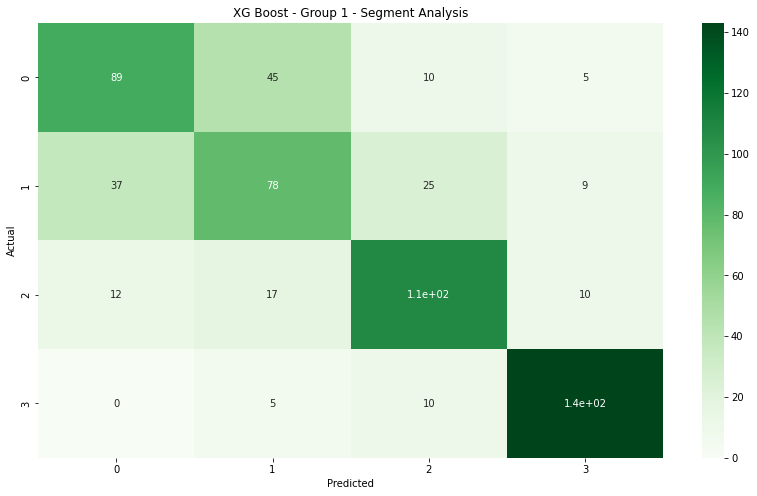

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[00:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:13:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7355193108477595; Accuracy score = 0.7412353923205343 ; Precisison Score = 0.7326524134847443; Recall score = 0.7412353923205343


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.63      0.64       142
           1       0.58      0.50      0.54       147
           2       0.74      0.82      0.78       148
           3       0.94      0.98      0.96       162

    accuracy                           0.74       599
   macro avg       0.73      0.73      0.73       599
weighted avg       0.73      0.74      0.74       599



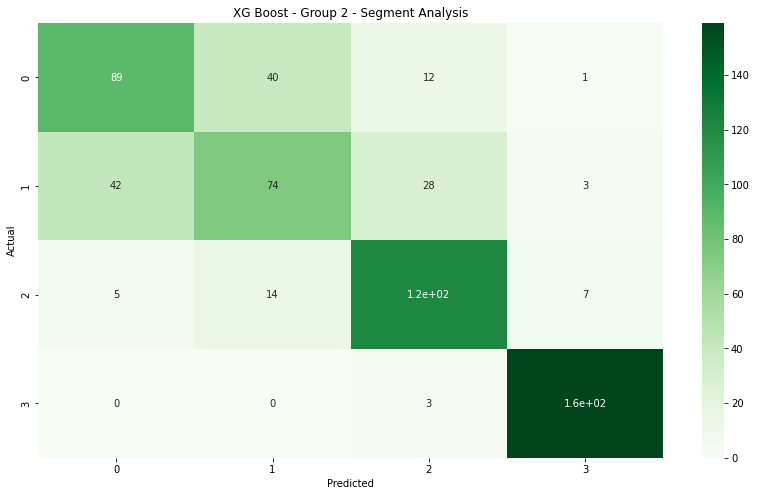

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
[00:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7852345458159412; Accuracy score = 0.7866666666666666 ; Precisison Score = 0.7911511387163561; Recall score = 0.7866666666666666


 Aggregate report 
               precision    recall  f1-score   support

           0       0.65      0.75      0.70        20
           1       0.89      0.89      0.89        18
           2       0.85      0.89      0.87        19
           3       0.79      0.61      0.69        18

    accuracy                           0.79        75
   macro avg       0.79      0.79      0.79        75
weighted avg       0.79      0.79      0.79        75



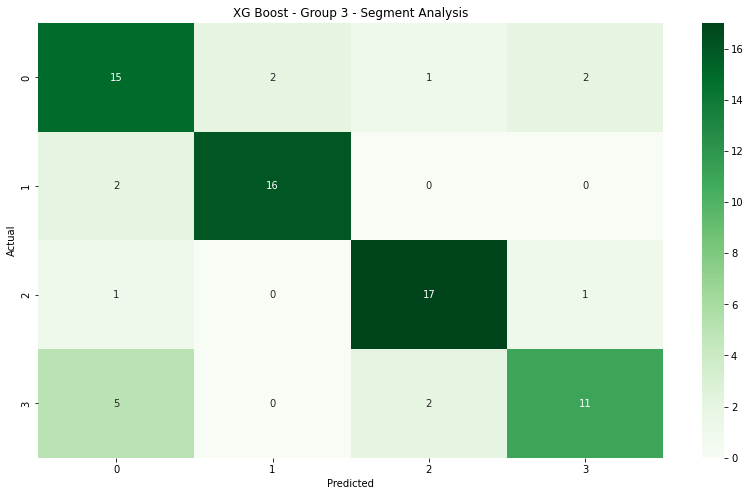

In [375]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
min_child_weight = [5, 1, 1]
gamma =[1, 1, 0.5]
subsample = [1.0,0.8,1.0]
colsample_bytree = [0.8, 0.6, 1.0]
max_depth = [5, 10,5]
alpha = [0.1, 0.1, 1]
lmbda = [3,1,6]
eta =  [ 1, 0.1, 0.1]

for i in range(3):
    myVar = {
      'lambda': lmbda[i],
    }
    xgtree = XGBClassifier(
      min_child_weight = min_child_weight[i],
      gamma = gamma[i],
      subsample = subsample[i],
      colsample_bytree = colsample_bytree[i],
      max_depth = max_depth[i],
      alpha = alpha[i],
      # lambda_ = lmbda[i],
      max_delta_step = 2,
      objective = 'reg:squarederror',
      eta =  eta[i],
      num_boost_round = 5,
      **myVar
    )

    temp_xg_df = copy.deepcopy(lst_df[i])

    for col in temp_xg_df:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_df[col] = temp_xg_df[col].astype(str).astype(float)

    actual, predicted, X_test_list[i] = run_model(xgtree, temp_xg_df, lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"XG Boost - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### XG Boost - Parent Analysis



 Aggregate report 
               precision    recall  f1-score   support

           0       0.57      0.56      0.57        50
           1       0.54      0.50      0.52        52
           2       0.64      0.69      0.67        49
           3       0.76      0.78      0.77        49

    accuracy                           0.63       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.63      0.63      0.63       200



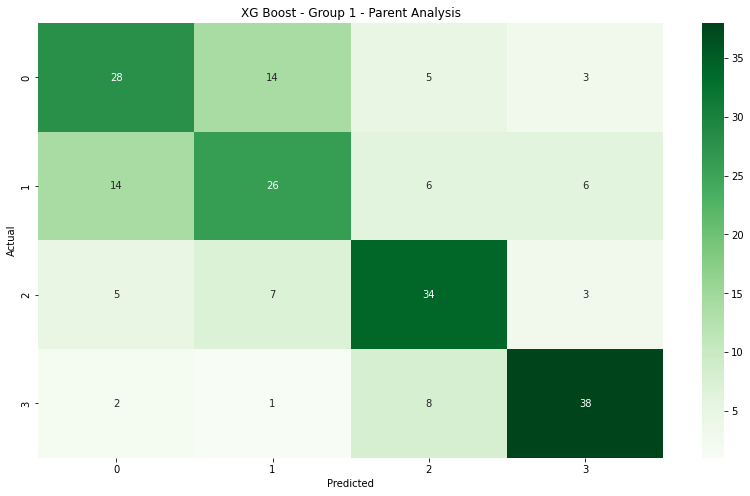



 Aggregate report 
               precision    recall  f1-score   support

           0       0.54      0.62      0.57        47
           1       0.53      0.37      0.44        51
           2       0.58      0.74      0.65        42
           3       0.86      0.79      0.82        38

    accuracy                           0.61       178
   macro avg       0.63      0.63      0.62       178
weighted avg       0.61      0.61      0.61       178



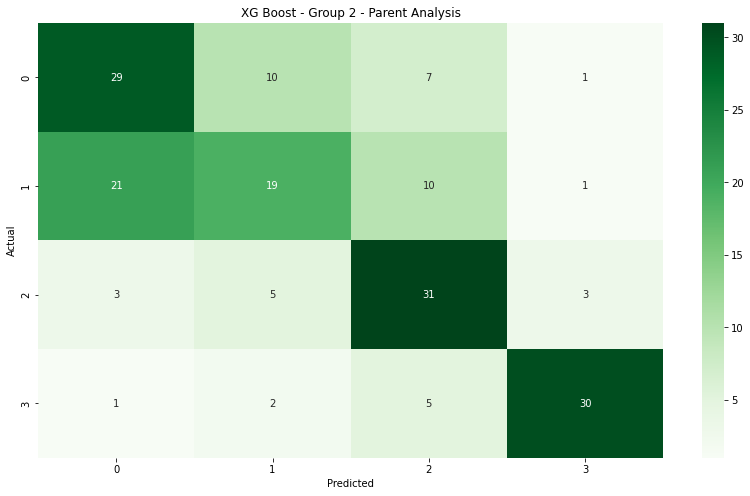



 Aggregate report 
               precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.62      0.83      0.71         6
           2       0.29      0.40      0.33         5
           3       0.80      0.57      0.67        14

    accuracy                           0.64        36
   macro avg       0.61      0.63      0.61        36
weighted avg       0.68      0.64      0.65        36



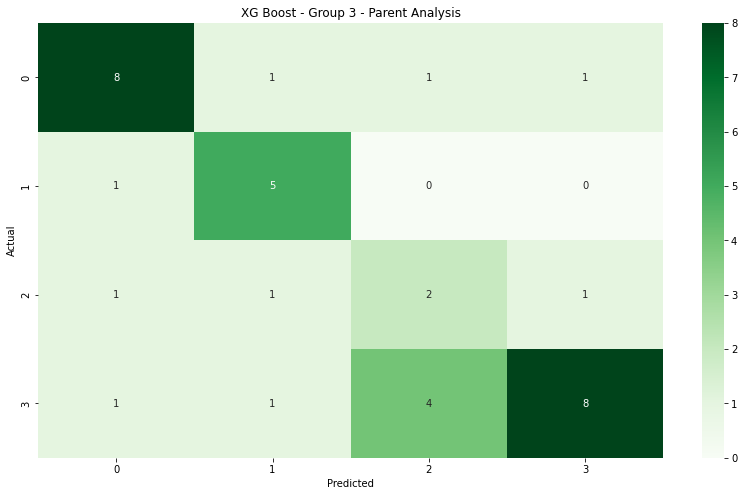

In [376]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"XG Boost - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

## Gradient Boosting

In [ ]:
quick_parameters = {
  'loss' : ["deviance"],
  'learning_rate' : [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.3],
  'min_samples_split' : np.linspace(0.01, 0.5, 14),
  'min_samples_leaf' : np.linspace(0.001, 0.5, 18),
  'max_depth' : [1,2,3,5,8],
  'max_features' : ["log2","sqrt"],
  'criterion' : ["friedman_mse",  "absolute_error"],
  'subsample' : [0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
  'n_estimators' : [10, 20, 30, 50]
}

gbtree = GradientBoostingClassifier()
hyperparameter_tuning_random(gbtree, data_balanced_np, label_balanced_np, quick_parameters)
hyperparameter_tuning_random(gbtree, data_balanced_non_noisy_np, label_balanced_non_noisy_np, quick_parameters)
hyperparameter_tuning_random(gbtree, data_balanced_noisy_np, label_balanced_noisy_np, quick_parameters)

***NOTE: The above code block takes a lot of time to run because it does a massive GridSearch. We have pasted the final results of the GridSearch below for all three groups:***

Group 1 (all data): {'subsample': 1.0, 'n_estimators': 20, 'min_samples_split': 0.047692307692307694, 'min_samples_leaf': 0.11841176470588236, 'max_features': 'sqrt', 'max_depth': 8, 'loss': 'deviance', 'learning_rate': 0.3, 'criterion': 'friedman_mse'}

Group 2 (non noisy): {'subsample': 1.0, 'n_estimators': 50, 'min_samples_split': 0.12307692307692307, 'min_samples_leaf': 0.001, 'max_features': 'log2', 'max_depth': 3, 'loss': 'deviance', 'learning_rate': 0.025, 'criterion': 'friedman_mse'}

Group 3 (noisy): {'subsample': 0.95, 'n_estimators': 20, 'min_samples_split': 0.12307692307692307, 'min_samples_leaf': 0.11841176470588236, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.1, 'criterion': 'friedman_mse'}

#### Gradient Boosting - Segment Analysis

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5726456284374473; Accuracy score = 0.5771144278606966 ; Precisison Score = 0.5707099207564599; Recall score = 0.5771144278606966


 Aggregate report 
               precision    recall  f1-score   support

           0       0.59      0.54      0.57       156
           1       0.45      0.41      0.43       154
           2       0.52      0.55      0.54       139
           3       0.71      0.81      0.76       154

    accuracy                           0.58       603
   macro avg       0.57      0.58      0.57       603
weighted avg       0.57      0.58      0.57       603



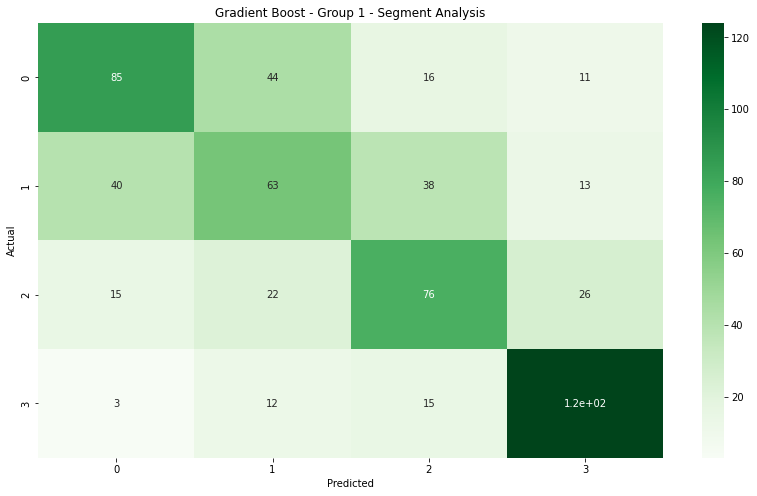

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.5552839246385508; Accuracy score = 0.5626043405676127 ; Precisison Score = 0.5567478158806235; Recall score = 0.5626043405676127


 Aggregate report 
               precision    recall  f1-score   support

           0       0.53      0.61      0.57       138
           1       0.49      0.40      0.44       158
           2       0.57      0.50      0.53       163
           3       0.63      0.78      0.70       140

    accuracy                           0.56       599
   macro avg       0.56      0.57      0.56       599
weighted avg       0.56      0.56      0.56       599



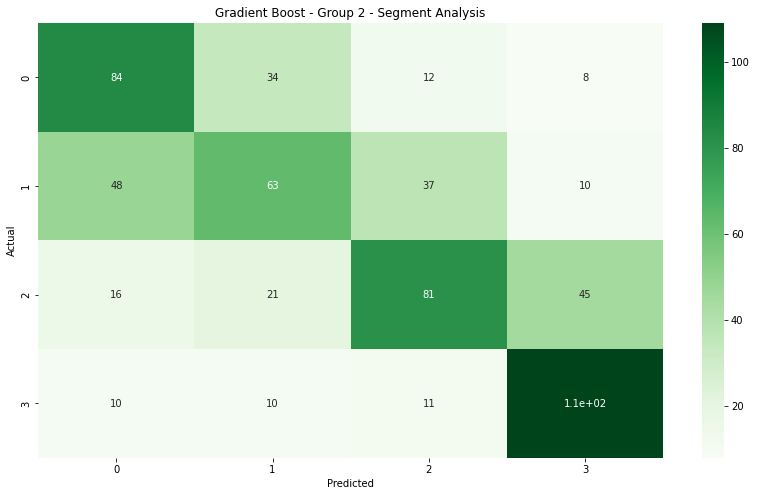

Feature set: Index(['analyse_harmonics', 'get_max_intensity', 'analyse_intensity',
       'analyse_pitch', 'analyse_pitch_range', 'analyse_shimmer',
       'analyse_jitter', 'spectral_slope', 'mean_spectral_rolloff',
       'get_energy'],
      dtype='object')
F1 score = 0.7851240358557432; Accuracy score = 0.7866666666666666 ; Precisison Score = 0.7938174312787315; Recall score = 0.7866666666666666


 Aggregate report 
               precision    recall  f1-score   support

           0       0.77      0.89      0.83        19
           1       0.94      0.94      0.94        17
           2       0.63      0.71      0.67        17
           3       0.82      0.64      0.72        22

    accuracy                           0.79        75
   macro avg       0.79      0.79      0.79        75
weighted avg       0.79      0.79      0.79        75



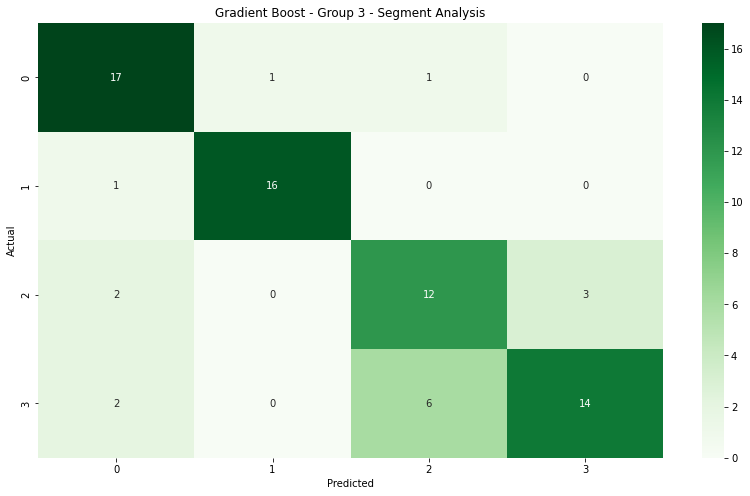

In [377]:
lst_label_np = [label_balanced_np, label_balanced_non_noisy_np, label_balanced_noisy_np]
label = 'segment_label_train'
lst_df = [standardized_aggression_df_balanced, standardized_non_noisy_df_balanced, standardized_noisy_df_balanced]
X_test_list = [None,None,None]
learning_rate = [0.3, 0.025, 0.1]
min_samples_split = [0.05, 0.12, 0.12]
min_samples_leaf = [0.12, 0.001, 0.12]
max_depth = [8, 3, 5]
max_features = ["sqrt","log2","sqrt"]
subsample = [1.0, 1.0, 0.95]
n_estimators = [20, 50, 20]

for i in range(3):
    gbtree = GradientBoostingClassifier(
      loss = "deviance",
      learning_rate = learning_rate[i],
      min_samples_split = min_samples_split[i],
      min_samples_leaf = min_samples_leaf[i],
      max_depth = max_depth[i],
      max_features = max_features[i],
      criterion = "friedman_mse",
      subsample = subsample[i],
      n_estimators = n_estimators[i]
    )
    actual, predicted, X_test_list[i] = run_model(gbtree, lst_df[i], lst_label_np[i],label_name=label)

    confusion_matrix_graph(f"Gradient Boost - Group {i+1} - Segment Analysis", actual, predicted, ['0', '1', '2', '3'])

#### Gradient Boosting - Parent Analysis



 Aggregate report 
               precision    recall  f1-score   support

           0       0.60      0.50      0.54        56
           1       0.41      0.34      0.37        53
           2       0.44      0.51      0.48        47
           3       0.57      0.70      0.63        50

    accuracy                           0.51       206
   macro avg       0.51      0.51      0.51       206
weighted avg       0.51      0.51      0.50       206



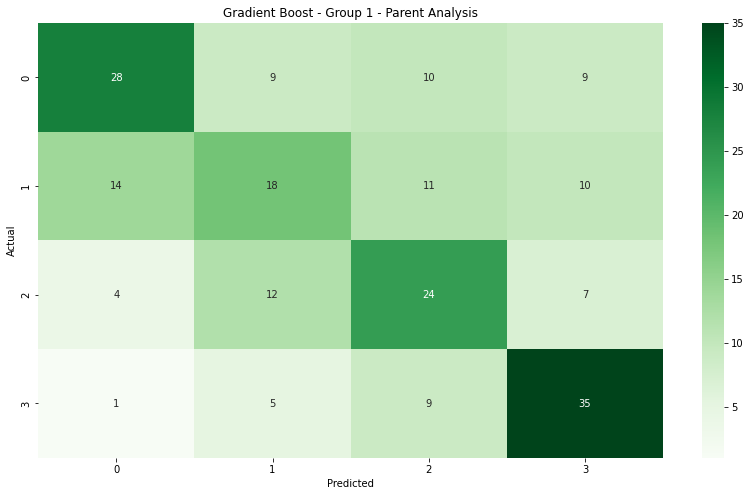



 Aggregate report 
               precision    recall  f1-score   support

           0       0.39      0.41      0.40        41
           1       0.44      0.33      0.38        48
           2       0.46      0.47      0.46        45
           3       0.56      0.68      0.61        40

    accuracy                           0.47       174
   macro avg       0.46      0.47      0.46       174
weighted avg       0.46      0.47      0.46       174



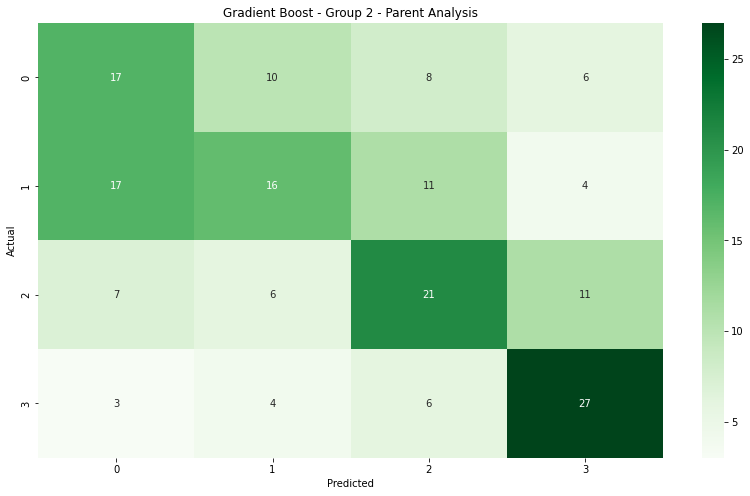



 Aggregate report 
               precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.57      0.67      0.62         6
           2       0.22      0.50      0.31         4
           3       1.00      0.50      0.67        16

    accuracy                           0.61        36
   macro avg       0.62      0.62      0.58        36
weighted avg       0.75      0.61      0.64        36



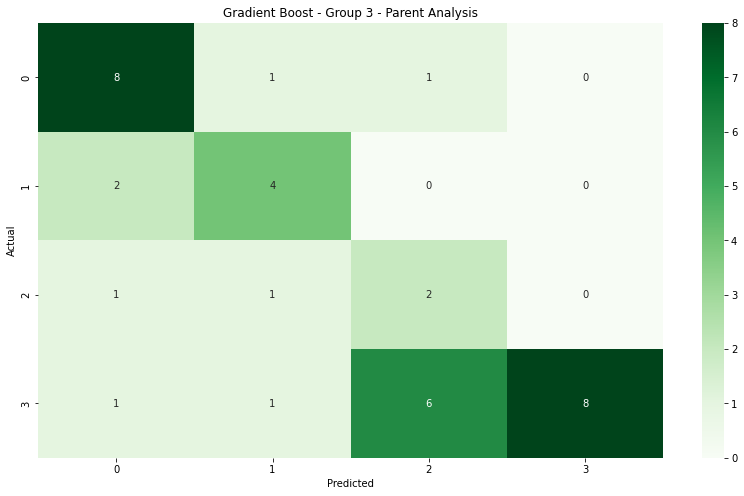

In [378]:
max_parent_df_list = []

for i in range(0,len(X_test_list)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list[i]
    #display(df_i)
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    #df_i = lst_df[i] 
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list.append(df_i_merged)
    
    confusion_matrix_graph(f"Gradient Boost - Group {i+1} - Parent Analysis", df_i_merged['parent_label_train'], df_i_merged['segment_predictions'], ['0', '1', '2', '3'])

## Plot the current results

In [379]:
import matplotlib.pyplot as plt

### Segment Analysis

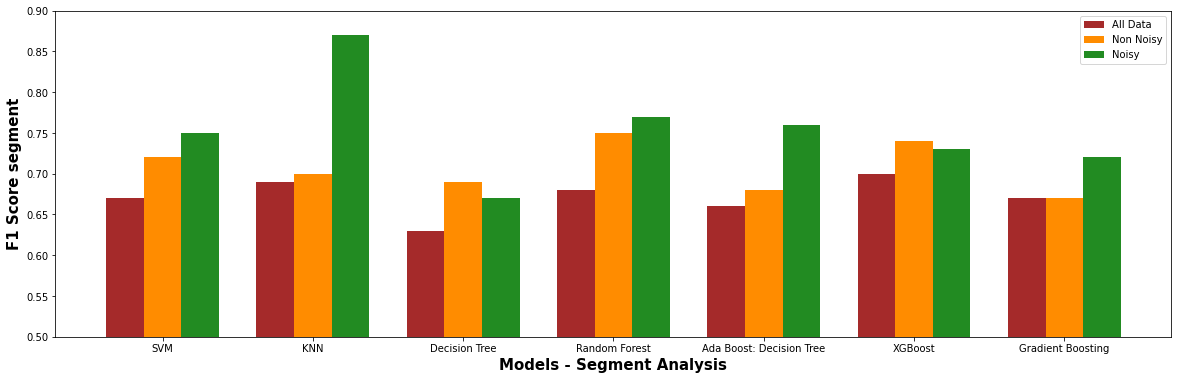

In [381]:
#f1 scores entered manually to control for randomization
f1_all = [0.67, 0.69, 0.63, 0.68, 0.66, 0.70, 0.67 ]
f1_non_noisy = [0.72, 0.70, 0.69, 0.75, 0.68, 0.74, 0.67]
f1_noisy = [0.75, 0.87, 0.67, 0.77, 0.76, 0.73, 0.72]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models - Segment Analysis', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score segment', fontweight ='bold', fontsize = 15)
plt.ylim([0.5, 0.9])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting'])
 
plt.legend()
plt.show()

### Parent Analysis

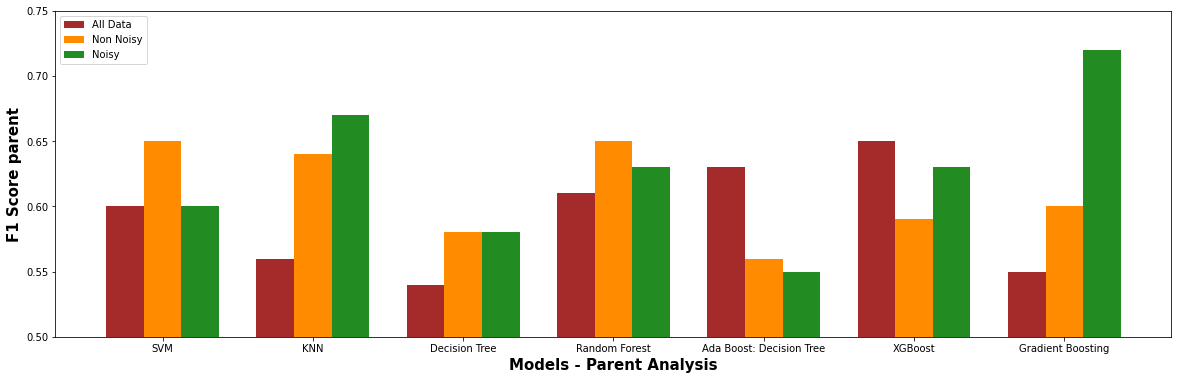

In [382]:
#f1 scores entered manually to control for randomization
f1_all = [0.60, 0.56, 0.54, 0.61, 0.63, 0.65, 0.55]
f1_non_noisy = [0.65, 0.64, 0.58, 0.65, 0.56, 0.59, 0.60]
f1_noisy = [0.60, 0.67, 0.58, 0.63, 0.55, 0.63, 0.72]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models - Parent Analysis', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score parent', fontweight ='bold', fontsize = 15)
plt.ylim([0.5, 0.75])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting'])
 
plt.legend()
plt.show()

# Ensemble of all methods

- **Just doing one test/train split for all models in the models below.**
- Validation is not required as we have set the hyper parameters then trained each of the models on this same training set

In [383]:
def run_model_pre_split(ml_model, X_train, X_test, y_train, y_test):
    model = copy.deepcopy(ml_model)
    
    # Only train on this feature set
    feature_set = X_train.drop(['parent_file_train']+feature_labels,axis=1).columns  # Only these features will be fed to the model
    
    actual_labels = np.empty([0], dtype=int)
    predicted_labels = np.empty([0], dtype=int)

    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    
    X_test['segment_predictions'] = y_pred  # To store prediction with rest of the data

    actual_labels = np.append(actual_labels, y_test)
    predicted_labels = np.append(predicted_labels, y_pred)

    acc_score = accuracy_score(y_test, y_pred)
    prec_score = precision_score(y_test, y_pred, average='weighted')
    rec_score = recall_score(y_test, y_pred, average='weighted')
    fone_score = f1_score(y_test, y_pred, average='weighted')

    print(f'F1 score = {fone_score}; Accuracy score = {acc_score} ; Precisison Score = {prec_score}; Recall score = {rec_score}')

    return actual_labels, predicted_labels, X_test

#### Train and Test data for all the three groups.

In [384]:
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(standardized_aggression_df_balanced, label_balanced_np, test_size=0.25)

In [385]:
X_train_non_noisy, X_test_non_noisy, y_train_non_noisy, y_test_non_noisy = train_test_split(standardized_non_noisy_df_balanced, label_balanced_non_noisy_np, test_size=0.25)

In [386]:
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(standardized_noisy_df_balanced, label_balanced_noisy_np, test_size=0.25)

## SVM - Final Model with the same train/test split

#### Segment Analysis

In [387]:
label = 'segment_label_train'
X_test_list_svm = [None,None,None]
kernel = ['rbf','rbf','poly']
gamma = ['auto', 'scale', 'auto']
c = [100000, 1000, 1000]
predicted_svm = [None, None, None]
actual_svm = [None, None, None]
X_train = [X_train_all, X_train_non_noisy, X_train_noisy]
X_test = [X_test_all, X_test_non_noisy, X_test_noisy]
y_train = [y_train_all, y_train_non_noisy, y_train_noisy]
y_test = [y_test_all, y_test_non_noisy, y_test_noisy]

for i in range(3):
    svm_model = svm.SVC(kernel=kernel[i], gamma=gamma[i], C=c[i], degree= 3)
    actual_svm[i], predicted_svm[i], X_test_list_svm[i] = run_model_pre_split(svm_model, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.6953242696792055; Accuracy score = 0.6998341625207297 ; Precisison Score = 0.69324871494023; Recall score = 0.6998341625207297
F1 score = 0.7042542904707794; Accuracy score = 0.7111853088480802 ; Precisison Score = 0.7016324831353262; Recall score = 0.7111853088480802
F1 score = 0.6501779701779701; Accuracy score = 0.6666666666666666 ; Precisison Score = 0.670017094017094; Recall score = 0.6666666666666666


#### Parent Analysis

In [388]:
max_parent_df_list_svm = [None, None, None]

for i in range(0,len(X_test_list_svm)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_svm[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_svm[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_svm[i]['segment_predictions'], max_parent_df_list_svm[i]['parent_label_train'], average='weighted')}")

F1 score = 0.6544176775848283
F1 score = 0.6141167887717989
F1 score = 0.4204533630620587


## KNN - Final Model with the same train/test split

#### Segment Analysis

In [389]:
X_test_list_knn = [None,None,None]
predicted_knn = [None, None, None]
actual_knn = [None, None, None]
metric = ['manhattan','manhattan','euclidean']

for i in range(3):
    knn = KNeighborsClassifier(n_neighbors= 1,algorithm='auto',leaf_size= 1, metric= metric[i],weights='uniform')
    actual_knn[i], predicted_knn[i], X_test_list_knn[i] = run_model_pre_split(knn, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.6789042673792242; Accuracy score = 0.693200663349917 ; Precisison Score = 0.6763902586501229; Recall score = 0.693200663349917
F1 score = 0.6911823869201215; Accuracy score = 0.7028380634390651 ; Precisison Score = 0.6880646874000118; Recall score = 0.7028380634390651
F1 score = 0.7556384505021521; Accuracy score = 0.76 ; Precisison Score = 0.7679503105590062; Recall score = 0.76


#### Parent Analysis

In [390]:
max_parent_df_list_knn = [None, None, None]

for i in range(0,len(X_test_list_knn)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_knn[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_knn[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_knn[i]['parent_label_train'], max_parent_df_list_knn[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6088391402863822
F1 score = 0.6197558446026485
F1 score = 0.6115187376725839


## Decision Tree - Final Model with the same train/test split

#### Segment Analysis

In [391]:
X_test_list_dt = [None,None,None]
predicted_dt = [None, None, None]
actual_dt = [None, None, None]
criterion = ['entropy','entropy','gini']
max_depth = [30,20,18]

for i in range(3):
    dtree = DecisionTreeClassifier(criterion=criterion[i], max_depth=max_depth[i])
    actual_dt[i], predicted_dt[i], X_test_list_dt[i] = run_model_pre_split(dtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.682693203394323; Accuracy score = 0.6915422885572139 ; Precisison Score = 0.679210240821954; Recall score = 0.6915422885572139
F1 score = 0.6674173659356784; Accuracy score = 0.67779632721202 ; Precisison Score = 0.6633741834936534; Recall score = 0.67779632721202
F1 score = 0.7564810893843152; Accuracy score = 0.76 ; Precisison Score = 0.7658263305322128; Recall score = 0.76


#### Parent Analysis

In [392]:
max_parent_df_list_dt = [None, None, None]

for i in range(0,len(X_test_list_dt)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_dt[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_dt[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_dt[i]['parent_label_train'], max_parent_df_list_dt[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6173502194400027
F1 score = 0.5427122387666353
F1 score = 0.5517664971106266


## Random Forest - Final Model with the same train/test split

#### Segment Analysis

In [393]:
X_test_list_rf = [None,None,None]
predicted_rf = [None, None, None]
actual_rf = [None, None, None]
n_estimators = [1600, 1600, 600]
max_features = ['sqrt', 'auto', 'auto']
max_depth = [122, 38, 80]

for i in range(3):
    rtree = RandomForestClassifier(
      n_estimators = n_estimators[i],
      max_features = max_features[i],
      max_depth = max_depth[i],
      min_samples_split = 5,
      min_samples_leaf = 1,
      bootstrap = 'False'
    )
    actual_rf[i], predicted_rf[i], X_test_list_rf[i] = run_model_pre_split(rtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.7377767351736897; Accuracy score = 0.7429519071310116 ; Precisison Score = 0.7345971752127867; Recall score = 0.7429519071310116
F1 score = 0.7507763040605386; Accuracy score = 0.7545909849749582 ; Precisison Score = 0.7481835588663717; Recall score = 0.7545909849749582
F1 score = 0.7610034114012802; Accuracy score = 0.76 ; Precisison Score = 0.7838941798941799; Recall score = 0.76


#### Parent Analysis

In [394]:
max_parent_df_list_rf = [None, None, None]

for i in range(0,len(X_test_list_rf)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_rf[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_rf[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_rf[i]['parent_label_train'], max_parent_df_list_rf[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6485424311454351
F1 score = 0.6488379973144547
F1 score = 0.5377183203270159


## Ada Boost with Decision tree base - Final Model with the same train/test split

#### Segment Analysis

In [395]:
X_test_list_ad = [None,None,None]
predicted_ad = [None, None, None]
actual_ad = [None, None, None]
n_estimators = [50, 20, 20]
learning_rate = [1, 1, 0.1]

for i in range(3):
    adtree = AdaBoostClassifier(base_estimator = dtree, n_estimators=n_estimators[i], learning_rate=learning_rate[i])
    actual_ad[i], predicted_ad[i], X_test_list_ad[i] = run_model_pre_split(adtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.6677887617112769; Accuracy score = 0.6799336650082919 ; Precisison Score = 0.6630394964994977; Recall score = 0.6799336650082919
F1 score = 0.72172195742915; Accuracy score = 0.7278797996661102 ; Precisison Score = 0.7190101962655913; Recall score = 0.7278797996661102
F1 score = 0.7308945868945869; Accuracy score = 0.7333333333333333 ; Precisison Score = 0.7525461088618983; Recall score = 0.7333333333333333


#### Parent Analysis

In [396]:
max_parent_df_list_ad = [None, None, None]

for i in range(0,len(X_test_list_ad)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_ad[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_ad[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_ad[i]['parent_label_train'], max_parent_df_list_ad[i]['segment_predictions'], average='weighted')}")

F1 score = 0.560842407758195
F1 score = 0.6199013690537332
F1 score = 0.5082403770186575


## XGBoost - Final Model with the same train/test split

#### Segment Analysis

In [397]:
X_test_list_xg = [None,None,None]
predicted_xg = [None, None, None]
actual_xg = [None, None, None]
min_child_weight = [5, 1, 1]
gamma =[1, 1, 0.5]
subsample = [1.0,0.8,1.0]
colsample_bytree = [0.8, 0.6, 1.0]
max_depth = [5, 10,5]
alpha = [0.1, 0.1, 1]
lmbda = [3,1,6]
eta =  [ 1, 0.1, 0.1]

for i in range(3):
    myVar = {
      'lambda': lmbda[i],
    }
    xgtree = XGBClassifier(
      min_child_weight = min_child_weight[i],
      gamma = gamma[i],
      subsample = subsample[i],
      colsample_bytree = colsample_bytree[i],
      max_depth = max_depth[i],
      alpha = alpha[i],
      # lambda_ = lmbda[i],
      max_delta_step = 2,
      objective = 'reg:squarederror',
      eta =  eta[i],
      num_boost_round = 5,
      **myVar
    )

    temp_xg_train = copy.deepcopy(X_train[i])

    for col in temp_xg_train:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_train[col] = temp_xg_train[col].astype(str).astype(float)

    temp_xg_test = copy.deepcopy(X_test[i])

    for col in temp_xg_test:
      if col not in ["parent_file_train", "parent_label_train", "segment_label_train", "noisy_train"]:
        temp_xg_test[col] = temp_xg_test[col].astype(str).astype(float)

    actual_xg[i], predicted_xg[i], X_test_list_xg[i] = run_model_pre_split(xgtree, temp_xg_train, temp_xg_test, y_train[i], y_test[i])

C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[00:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:18:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score = 0.6961317730966671; Accuracy score = 0.703150912106136 ; Precisison Score = 0.692602094236682; Recall score = 0.703150912106136
[00:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost

C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7243495235907289; Accuracy score = 0.7295492487479132 ; Precisison Score = 0.7207835259671761; Recall score = 0.7295492487479132
[00:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\samee\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1 score = 0.7638821393660102; Accuracy score = 0.76 ; Precisison Score = 0.7905250305250305; Recall score = 0.76


#### Parent Analysis

In [398]:
max_parent_df_list_xg = [None, None, None]

for i in range(0,len(X_test_list_xg)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_xg[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_xg[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_xg[i]['parent_label_train'], max_parent_df_list_xg[i]['segment_predictions'], average='weighted')}")

F1 score = 0.6090311021865679
F1 score = 0.6477509290631751
F1 score = 0.5831760396466279


## Gradient Boosting - Final Model with the same train/test split

#### Segment Analysis

In [399]:
X_test_list_gb = [None,None,None]
predicted_gb = [None, None, None]
actual_gb = [None, None, None]
learning_rate = [0.3, 0.025, 0.1]
min_samples_split = [0.05, 0.12, 0.12]
min_samples_leaf = [0.12, 0.001, 0.12]
max_depth = [8, 3, 5]
max_features = ["sqrt","log2","sqrt"]
subsample = [1.0, 1.0, 0.95]
n_estimators = [20, 50, 20]

for i in range(3):
    gbtree = GradientBoostingClassifier(
      loss = "deviance",
      learning_rate = learning_rate[i],
      min_samples_split = min_samples_split[i],
      min_samples_leaf = min_samples_leaf[i],
      max_depth = max_depth[i],
      max_features = max_features[i],
      criterion = "friedman_mse",
      subsample = subsample[i],
      n_estimators = n_estimators[i]
    )
    actual_gb[i], predicted_gb[i], X_test_list_gb[i] = run_model_pre_split(gbtree, X_train[i], X_test[i], y_train[i], y_test[i])

F1 score = 0.5689908993318081; Accuracy score = 0.5704809286898839 ; Precisison Score = 0.5684676700602541; Recall score = 0.5704809286898839
F1 score = 0.5863643148881201; Accuracy score = 0.5943238731218697 ; Precisison Score = 0.5860138176639383; Recall score = 0.5943238731218697
F1 score = 0.707570278352887; Accuracy score = 0.7066666666666667 ; Precisison Score = 0.7472283272283272; Recall score = 0.7066666666666667


#### Parent Analysis

In [400]:
max_parent_df_list_gb = [None, None, None]

for i in range(0,len(X_test_list_gb)):
    # Each dataset: agg, non oisy and noisy, find max segment predictions for each parent_file_train
    df_i = X_test_list_gb[i]
    df_i_merged = df_i.groupby('parent_file_train')['segment_predictions'].max().reset_index()
    
    # Get parent label for each parent_file
    df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
    df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
    max_parent_df_list_gb[i] = df_i_merged
    print(f"F1 score = {f1_score(max_parent_df_list_gb[i]['parent_label_train'], max_parent_df_list_gb[i]['segment_predictions'], average='weighted')}")

F1 score = 0.4847481699613661
F1 score = 0.49542152809723033
F1 score = 0.552272280149518


## Ensemble

### Group 1 - All data

In [401]:
predicted_all = [predicted_svm[0],predicted_knn[0], predicted_dt[0], predicted_rf[0], predicted_ad[0], predicted_xg[0], predicted_gb[0]]

Equally balanced models, i.e. max vote

In [402]:
label = [0] * len(predicted_all[0])

for i in range(len(predicted_all[0])):
  for model in predicted_all:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [403]:
final_all_label = [round(x) for x in label]

Calculate f1 score

In [404]:
fone_score = f1_score(y_test_all, final_all_label, average='weighted')
print(fone_score)

0.718940231362671


Fetch parent labels

In [405]:
X_test_list_gb[0]["ensemble"] = final_all_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[0]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[0] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[0]['parent_label_train'], max_parent_df_list_gb[0]['ensemble'], average='weighted')}")

F1 score = 0.5968404072609171


### Group 2 - Non Noisy data

In [406]:
predicted_non_noisy = [predicted_svm[1],predicted_knn[1], predicted_dt[1], predicted_rf[1], predicted_ad[1], predicted_xg[1], predicted_gb[1]]

Equally balanced models, i.e. max vote

In [407]:
label = [0] * len(predicted_non_noisy[0])

for i in range(len(predicted_non_noisy[0])):
  for model in predicted_non_noisy:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [408]:
final_non_noisy_label = [round(x) for x in label]

Calculate f1 score

In [409]:
fone_score = f1_score(y_test_non_noisy, final_non_noisy_label, average='weighted')
print(fone_score)

0.7603814494867743


Fetch parent labels

In [410]:
X_test_list_gb[1]["ensemble"] = final_non_noisy_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[1]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[1] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[1]['parent_label_train'], max_parent_df_list_gb[1]['ensemble'], average='weighted')}")

F1 score = 0.6415885277334444


### Group 3 - Noisy data

In [411]:
predicted_noisy = [predicted_svm[2],predicted_knn[2], predicted_dt[2], predicted_rf[2], predicted_ad[2], predicted_xg[2], predicted_gb[2]]

Equally balanced models, i.e. max vote

In [412]:
label = [0] * len(predicted_noisy[0])

for i in range(len(predicted_noisy[0])):
  for model in predicted_noisy:
    label[i] = label[i] + model[i]
  label[i] = label[i]/7

round to label

In [413]:
final_noisy_label = [round(x) for x in label]

Calculate f1 score

In [414]:
fone_score = f1_score(y_test_noisy, final_noisy_label, average='weighted')
print(fone_score)

0.6961866584438278


Fetch parent labels

In [415]:
X_test_list_gb[2]["ensemble"] = final_noisy_label

max_parent_df_list_gb = [None, None, None]


df_i = X_test_list_gb[2]
df_i_merged = df_i.groupby('parent_file_train')['ensemble'].max().reset_index()

# Get parent label for each parent_file
df_i_2 = df_i.groupby('parent_file_train')['parent_label_train'].max().reset_index()
df_i_merged = df_i_2.merge(df_i_merged, on='parent_file_train')
max_parent_df_list_gb[2] = df_i_merged
print(f"F1 score = {f1_score(max_parent_df_list_gb[2]['parent_label_train'], max_parent_df_list_gb[2]['ensemble'], average='weighted')}")

F1 score = 0.5968132744448534


# Visualize final models with the same test set

## Segment Analysis

Hard coded values to avoid randomization of splits

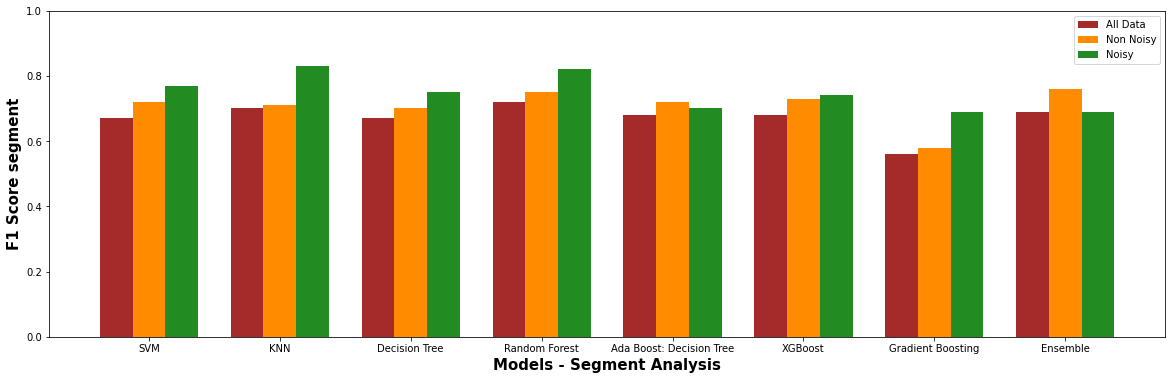

In [418]:
#f1 scores entered manually to control for randomization
f1_all = [0.67, 0.70, 0.67, 0.72, 0.68, 0.68, 0.56, 0.69]
f1_non_noisy = [0.72, 0.71, 0.70, 0.75, 0.72, 0.73, 0.58, 0.76]
f1_noisy = [0.77, 0.83, 0.75, 0.82, 0.70, 0.74, 0.69, 0.69]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models - Segment Analysis', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score segment', fontweight ='bold', fontsize = 15)
plt.ylim([0, 1])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting', 'Ensemble'])
 
plt.legend()
plt.show()

## Parent Analysis

Hard coded values to avoid randomization of splits

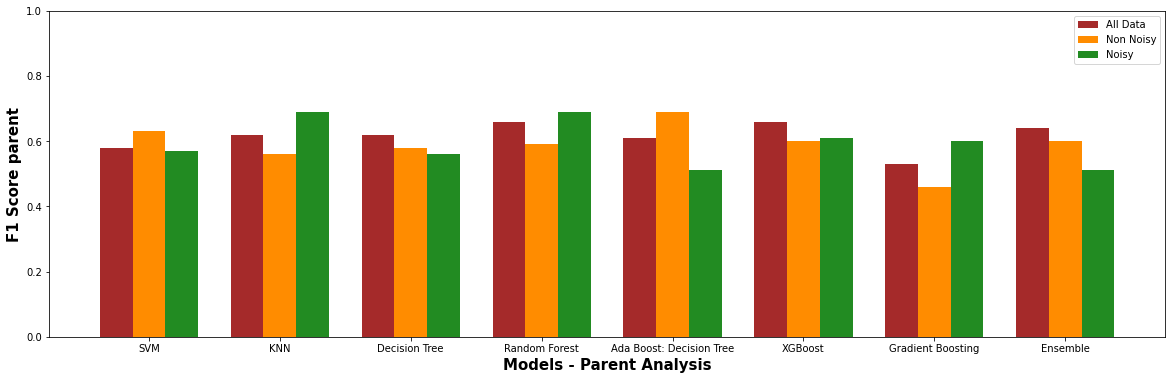

In [419]:
#f1 scores entered manually to control for randomization
f1_all = [0.58, 0.62, 0.62, 0.66, 0.61, 0.66, 0.53, 0.64]
f1_non_noisy = [0.63, 0.56, 0.58, 0.59, 0.69, 0.60, 0.46, 0.60]
f1_noisy = [0.57, 0.69, 0.56, 0.69, 0.51, 0.61, 0.60, 0.51]
    
barWidth = 0.25
fig = plt.subplots(figsize =(20, 6))
 
# Set position of bar on X axis
br1 = np.arange(len(f1_all))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, f1_all, color ='brown', width = barWidth, label ='All Data')
plt.bar(br2, f1_non_noisy, color ='darkorange', width = barWidth, label ='Non Noisy')
plt.bar(br3, f1_noisy, color ='forestgreen', width = barWidth, label ='Noisy')
 
# Adding Xticks
plt.xlabel('Models - Parent Analysis', fontweight ='bold', fontsize = 15)
plt.ylabel('F1 Score parent', fontweight ='bold', fontsize = 15)
plt.ylim([0, 1])
plt.xticks([r + barWidth for r in range(len(f1_all))],
        ['SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Ada Boost: Decision Tree', 'XGBoost', 'Gradient Boosting', 'Ensemble'])
 
plt.legend()
plt.show()